*   x.4 = Diffential ML in tensorflow : with Siren as backbone or not
*   x.5 = Diffential ML in pytorch with Siren as backbone
*   x.6 = Diffential ML in pytorch with MLP as backbone

# **0) Workspace**

*Once this cell is successfully executed you can comment on it and execute all the notebook cells at once*

In [51]:
%cd /content
! git clone https://github.com/Tikquuss/lwd
%cd lwd/scripts

In [52]:
try:
    %tensorflow_version 1.x
    %matplotlib inline
except Exception:
    pass

import tensorflow as tf 
import torch
import torch.nn.functional as F
import numpy as np
import random

from utils import genData, plotFunction, plotGrad, get_data_loader, MLP_Relu, train, plot_stat
from diff_ml_utils import graph, Generator, get_diffML_data_loader

# to avoid collision
from utils import Siren as tf_Siren
from utils import test
from diff_ml_utils import test as diff_ml_test 
from diff_ml_utils_tf import test as diff_ml_test_tf_siren

from functions import * # Styblinski-Tang, Ackley, Beale, Booth, Bukin, McCormick, Rosenbrock 
from twin_net import Siren, MLP, TwinNet

In [53]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_random_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [54]:
nTrain = 20 
nTest = 10

HIDDEN_DIM = 20
INPUT_DIM = 2
N_HIDDEN = 4 # Number of hidden layers (except input and output layers)
model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features" : 1}
                
generator_kwargs = {"hidden_units" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN}
siren_model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                      "out_features": 1, "outermost_linear" : False, 
                      "first_omega_0" : 30, "hidden_omega_0" : 30.}

mlp_model_kwargs = {"in_features" : INPUT_DIM, "hidden_features" : HIDDEN_DIM, "hidden_layers" : N_HIDDEN, 
                "out_features": 1, 
                "activation_function" : F.softplus, # This is what was done in the original code.
                "deriv_activation_function" : F.sigmoid}

max_epoch = 2
improving_limit = 1

batch_size = 512

learning_rate = 0.0001
learning_rate_schedule=[ (0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

train_seed, test_seed = 0, 0

first_omega_0 = 30
hidden_omega_0 = 30.
outermost_linear = True

**To avoid repeating the same code too much**

In [55]:
def run_train(model_class, model_kwargs,  with_derivative, name_function, name_grad, normalize = False):
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y

    if with_derivative :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, 
                                            batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = None, 
                                           batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = None, batch_size = batch_size)

    config["learning_rate_schedule"] = learning_rate_schedule
    config["description"] = ""

    model = model_class(**model_kwargs)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    model, stats, best_loss = train(model, train_dataloader, optimizer, criterion, with_derivative = with_derivative, max_epoch = max_epoch, improving_limit = improving_limit)

    plot_stat(stats, with_derivative = with_derivative)

    test_loss = test(model, test_dataloader, criterion, with_derivative = with_derivative)

    plotFunction(name = name_function, model = model, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, model = model, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

    return model, test_loss

def run_diffML_train(name, generator, generator_kwargs, name_function, name_grad, siren = False):
    global nTrain, nTest, train_seed, test_seed
    global min_x, max_x, step_x, min_y, max_y, step_y
    global max_epoch
    global first_omega_0, hidden_omega_0, outermost_linear
    if siren :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas = diff_ml_test_tf_siren(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch,
              first_omega_0 = first_omega_0, 
              hidden_omega_0 = hidden_omega_0, 
              outermost_linear = outermost_linear
          )
    else :
        loss, regressor, dtrain, dtest, dydxTest, values, deltas = diff_ml_test(
              generator, [nTrain], 
              nTrain, nTest, 
              trainSeed = train_seed, testSeed = test_seed, weightSeed = 0, 
              deltidx=0,
              generator_kwargs = generator_kwargs,
              epochs = max_epoch
          )
        
    plotFunction(name = name_function, function =  lambda x : regressor.predict_values([x])[0][0], 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)

    plotGrad(name = name_grad, 
            deriv_function = lambda index : lambda x : regressor.predict_values_and_derivs([x])[1][0][index], 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

    show_graph_per_axis = True 
    input_dim = 2
    yTest = dtest[1]
    if show_graph_per_axis :
        assert input_dim
        for i in range(input_dim) :
            xAxis  = np.array([[x[i]] for x in dtest[0]])
            # show predicitions
            graph("%s x%d vs y" % (name, (i+1)), values, xAxis, "", "values", yTest, [nTrain], True)
            # show deltas
            graph("%s x%d vs dxdy" % (name, (i+1)), deltas, xAxis, "", "deltas", dydxTest, [nTrain], True)

    return regressor, loss

def run_twinNet_train(model_class, model_kwargs,  with_derivative, name_function, name_grad, lam = 1, normalize = False):
    global learning_rate_schedule
    global x_train, y_train, dydx_train, x_test, y_test, dydx_test 
    global batch_size, learning_rate, max_epoch, improving_limit
    global min_x, max_x, step_x, min_y, max_y, step_y

    if with_derivative :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = dydx_train, 
                                            batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = dydx_test, batch_size = batch_size)
    else :
        train_dataloader, config = get_data_loader(x = x_train, y = y_train,  dydx = None, 
                                           batch_size = batch_size, normalize = normalize)
        test_dataloader, _ = get_data_loader(x = x_test, y = y_test,  dydx = None, batch_size = batch_size)

    config["learning_rate_schedule"] = learning_rate_schedule
    config["description"] = ""

    model = model_class(**model_kwargs)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    tn = TwinNet(model = model, optimizer = optimizer, criterion = criterion)

    tn.train(train_dataloader, config, lam, with_derivative, max_epoch, improving_limit)

    plot_stat(tn.stats, with_derivative)

    if with_derivative :
        loss, _, _, (yTest, dydxTest, values, deltas) = tn.test(test_dataloader, config, lam, with_derivative)
    else :
        loss, (yTest, values) = tn.test(test_dataloader, config, lam, with_derivative)
  

    plotFunction(name = name_function, model = tn.model, 
                 min_x = min_x, max_x = max_x, step_x = step_x, 
                 min_y = min_y, max_y = max_y, step_y = step_y)
    
    # todo
    """
    plotGrad(name = name_grad, model = tn.model, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)
    """
    
    return tn, loss

# **1) Styblinski-Tang function** : https://www.sfu.ca/~ssurjano/stybtang.html  

In [56]:
min_x = -5 
max_x = 5
step_x = 0.25 
min_y = -5 
max_y = 5
step_y = 0.25

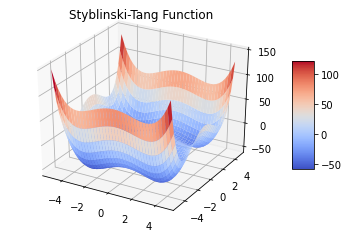

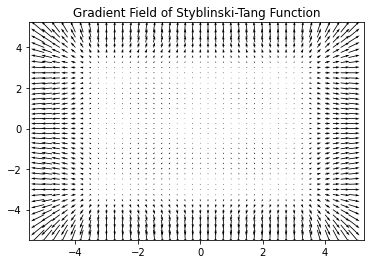

In [57]:
plotFunction(name = 'Styblinski-Tang Function', function = STFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Styblinski-Tang Function', deriv_function = STDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [58]:
batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = STFunction, 
                        deriv_function = STDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **1.1) Normal Training**

In [59]:
with_derivative = False
name_function = 'Styblinski-Tang Function normal training'
name_grad = 'Gradient Field of Styblinski-Tang Function normal training'

Epoch 0: train loss: 1819.652099609375
Epoch 1: train loss: 1819.637939453125
test loss: 1038.765869140625


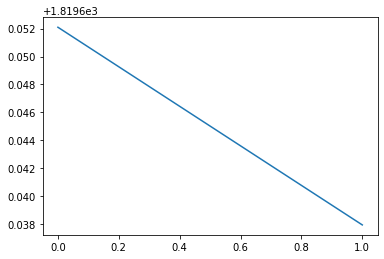

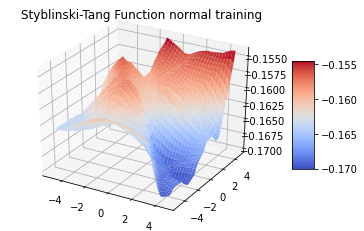

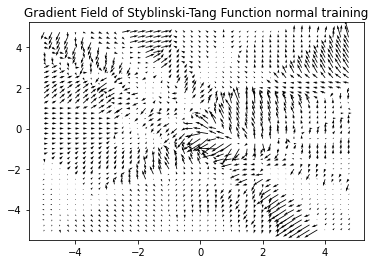

In [60]:
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

In [61]:
#model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad, normalize = True)

## **1.2) Sobolev Training**

In [62]:
with_derivative = True
name_function = 'Styblinski-Tang Function  sobolev training'
name_grad = 'Gradient Field of Styblinski-Tang Function sobolev training'

Epoch 0: train loss: 4281.560546875, y loss : 1820.1201171875, dy loss : 2461.440673828125
Epoch 1: train loss: 4281.5498046875, y loss : 1820.110595703125, dy loss : 2461.439453125
test loss: 4465.263671875, y loss : 1038.7125244140625, dy loss : 3426.55126953125


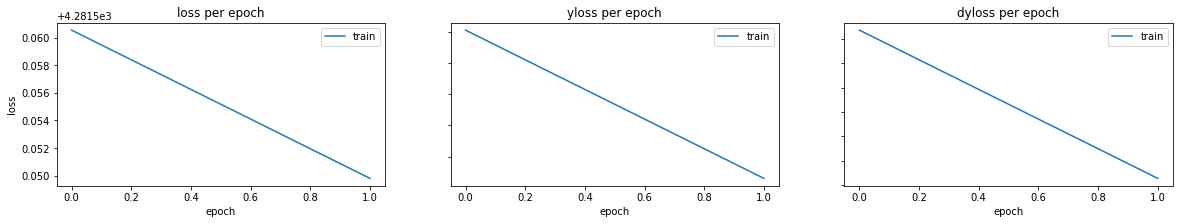

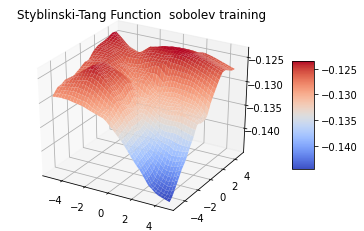

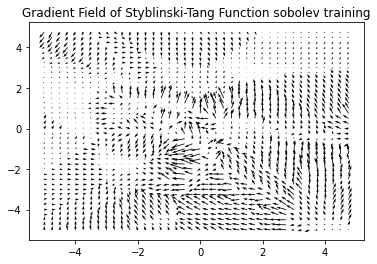

In [63]:
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

In [64]:
#model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad, normalize = True)

## **1.3) Siren**

In [65]:
with_derivative = True
name_function = 'Styblinski-Tang Function Siren'
name_grad = 'Gradient Field of Styblinski-Tang Function Siren'
model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})

Epoch 0: train loss: 4279.3701171875, y loss : 1821.375, dy loss : 2457.995361328125
Epoch 1: train loss: 4274.791015625, y loss : 1821.3717041015625, dy loss : 2453.41943359375
test loss: 4477.63671875, y loss : 1038.803955078125, dy loss : 3438.832763671875


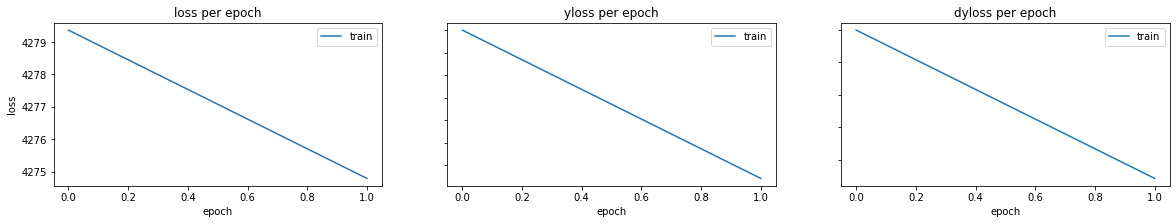

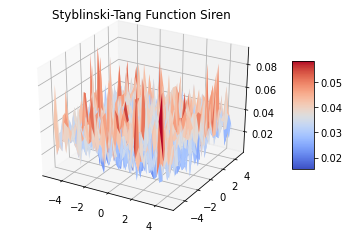

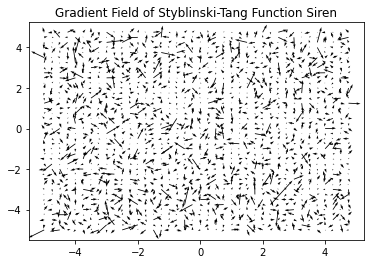

In [66]:
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

In [67]:
#model, test_loss = run_train(tf_Siren, model_kwargs,  with_derivative, name_function, name_grad, normalize = True)

## **1.4) Differential ML**

In [68]:
generator = Generator(callable_function = STFunction, callable_function_deriv = STDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Styblinski-Tang Differential ML"
name_function = 'Styblinski-Tang Function Differential ML'
name_grad = 'Gradient Field of Styblinski-Tang Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 5977.163
standard_dyloss : 1995.2129
differential_yloss : 4443.936
differential_dyloss : 1976.8744
[[5977.163], [1995.2129], [4443.936], [1976.8744]]


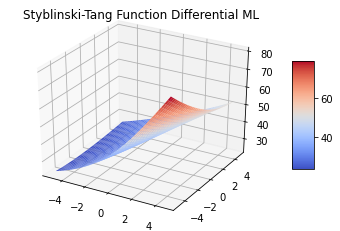

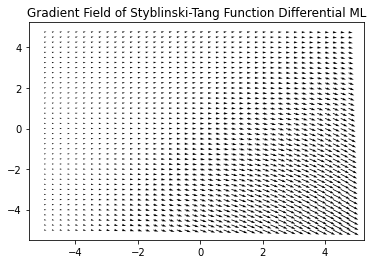

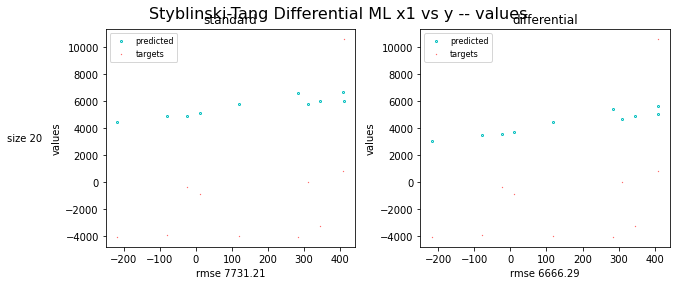

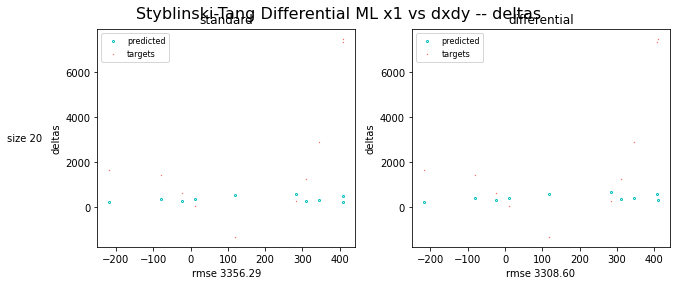

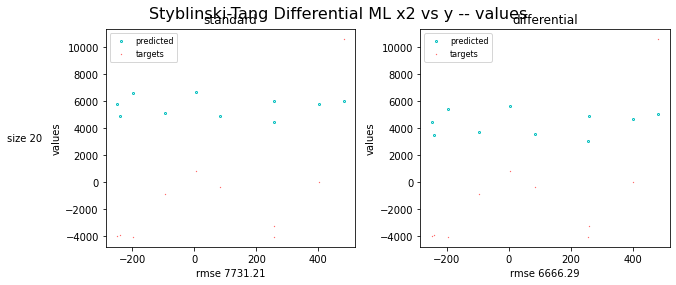

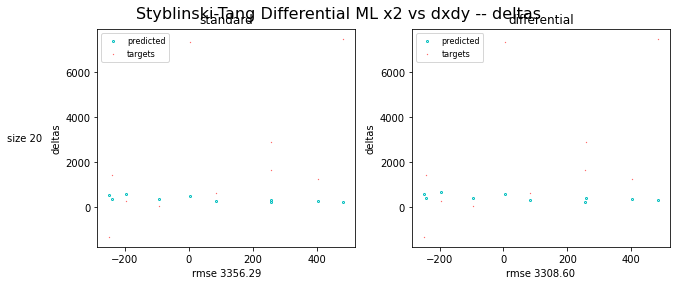

In [69]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 90649816.0
standard_dyloss : 145407840.0
differential_yloss : 69221336.0
differential_dyloss : 93797656.0
[[90649816.0], [145407840.0], [69221336.0], [93797656.0]]


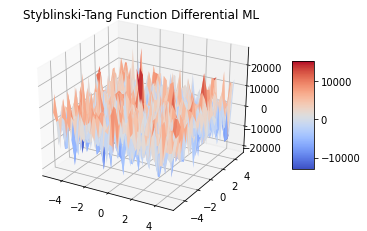

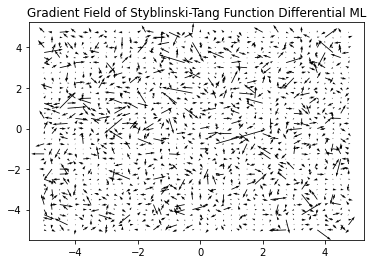

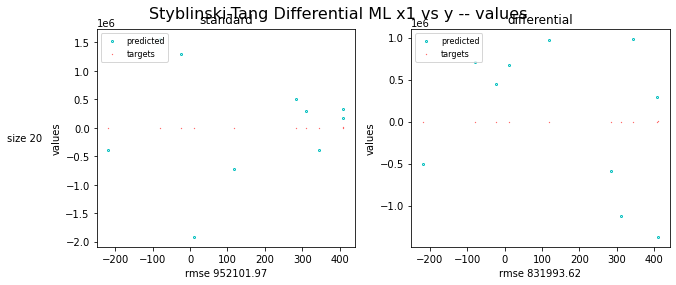

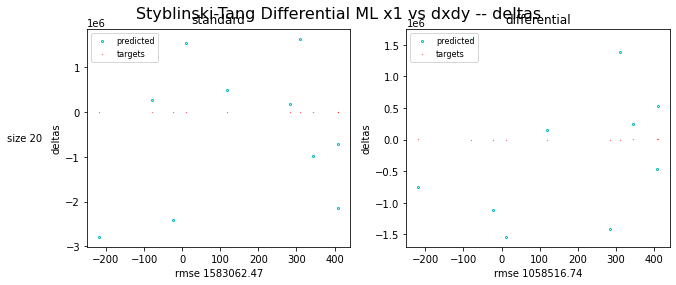

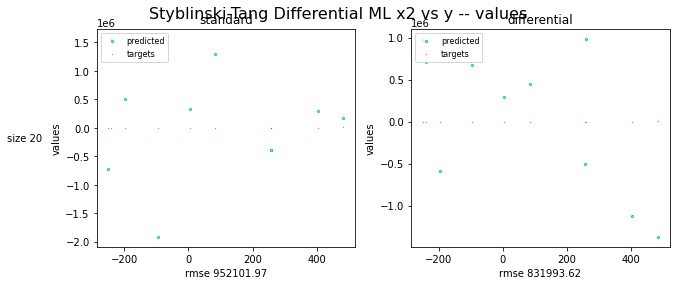

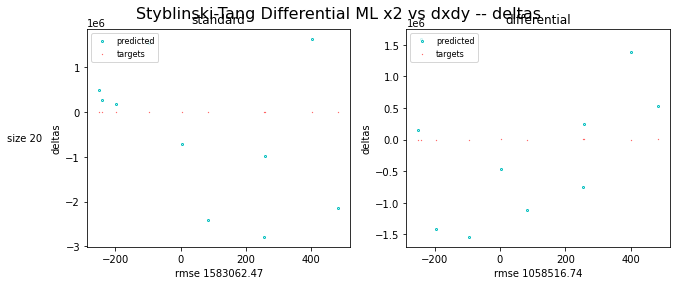

In [70]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **1.5) twin_net with siren**

In [71]:
with_derivative = True      
name_function = 'Styblinski-Tang Function Twin_net & Siren'
name_grad = 'Gradient Field of Styblinski-Tang Function Twin_net & Siren'

Epoch 0: train loss: 4244.27294921875, y loss : 1804.90234375, dy loss : 2439.37060546875
train loss no scaled: 4244.27294921875, y loss  no scaled : 1804.90234375, dy loss  no scaled: 2439.37060546875
Epoch 1: train loss: 4285.41162109375, y loss : 1816.7578125, dy loss : 2468.65380859375
train loss no scaled: 4285.41162109375, y loss  no scaled : 1816.7578125, dy loss  no scaled: 2468.65380859375
test loss: 4425.30078125, y loss : 1047.2427978515625, dy loss : 3378.05810546875
test loss no scaled: 4425.3009033203125, y loss  no scaled : 1047.2427978515625, dy loss  no scaled: 3378.05810546875



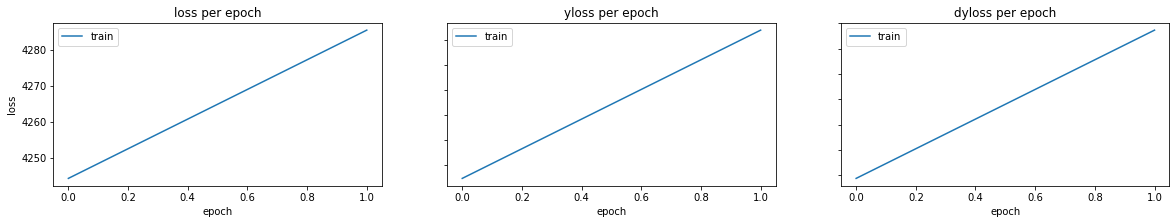

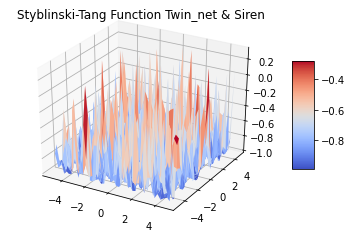

In [72]:
with_derivative = True      
name_function = 'Styblinski-Tang Function Twin_net & Siren'
name_grad = 'Gradient Field of Styblinski-Tang Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

In [73]:
"""
twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad,
                                  normalize = True
                                  )
"""

'\ntwinNet, loss = run_twinNet_train(model_class = Siren, \n                                  model_kwargs = siren_model_kwargs, \n                                  with_derivative = with_derivative,\n                                  name_function = name_function, \n                                  name_grad = name_grad,\n                                  normalize = True\n                                  )\n'

## **1.6) twin_net with MLP**

In [74]:
with_derivative = True      
name_function = 'Styblinski-Tang Function Twin_net & MLP'
name_grad = 'Gradient Field of Styblinski-Tang Function Twin_net & MLP'

Epoch 0: train loss: 4289.287109375, y loss : 1827.93359375, dy loss : 2461.353515625
train loss no scaled: 4289.287109375, y loss  no scaled : 1827.93359375, dy loss  no scaled: 2461.353515625
Epoch 1: train loss: 4289.265625, y loss : 1827.912841796875, dy loss : 2461.352783203125
train loss no scaled: 4289.265625, y loss  no scaled : 1827.912841796875, dy loss  no scaled: 2461.352783203125

test loss: 4464.9375, y loss : 1038.506591796875, dy loss : 3426.430908203125
test loss no scaled: 4464.9375, y loss  no scaled : 1038.506591796875, dy loss  no scaled: 3426.430908203125


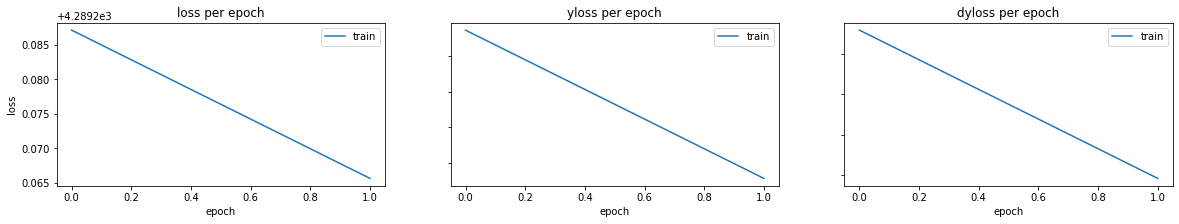

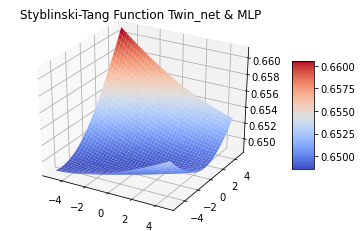

In [75]:
twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

In [76]:
"""
twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad,
                                  normalize = True
                                  )
"""

'\ntwinNet, loss = run_twinNet_train(model_class = MLP, \n                                  model_kwargs = mlp_model_kwargs, \n                                  with_derivative = with_derivative,\n                                  name_function = name_function, \n                                  name_grad = name_grad,\n                                  normalize = True\n                                  )\n'

# **2) Ackley function** : http://www.sfu.ca/~ssurjano/ackley.html 


**Recommended variable values are: a=20, b=0.2 and c=2π**

In [77]:
min_x = -5
max_x = 5
step_x = 0.25 
min_y = -5
max_y = 5
step_y = 0.25

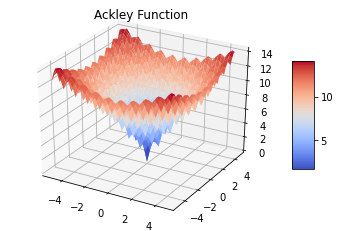

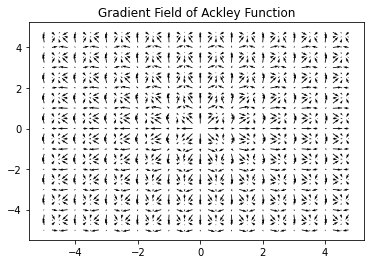

In [78]:
plotFunction(name = 'Ackley Function', function = AckleyFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Ackley Function', deriv_function = AckleyDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [79]:
batch_samples = genData(
                        function = AckleyFunction, 
                        deriv_function = AckleyDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = AckleyFunction, 
                        deriv_function = AckleyDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **2.1) Normal Training**

Epoch 0: train loss: 100.32391357421875
Epoch 1: train loss: 100.30113220214844
test loss: 83.2141342163086


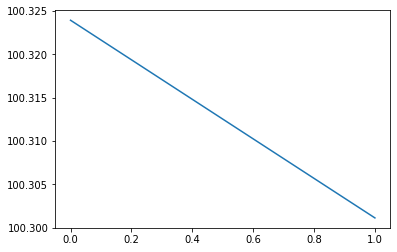

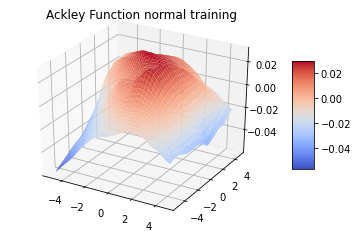

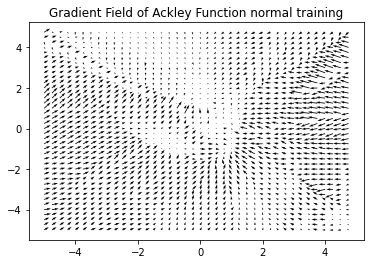

In [80]:
with_derivative = False
name_function = 'Ackley Function normal training'
name_grad = 'Gradient Field of Ackley Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **2.2) Sobolov Training**

Epoch 0: train loss: 106.57840728759766, y loss : 97.9356689453125, dy loss : 8.642736434936523
Epoch 1: train loss: 106.55801391601562, y loss : 97.91548156738281, dy loss : 8.642528533935547
test loss: 93.16966247558594, y loss : 80.85464477539062, dy loss : 12.315019607543945


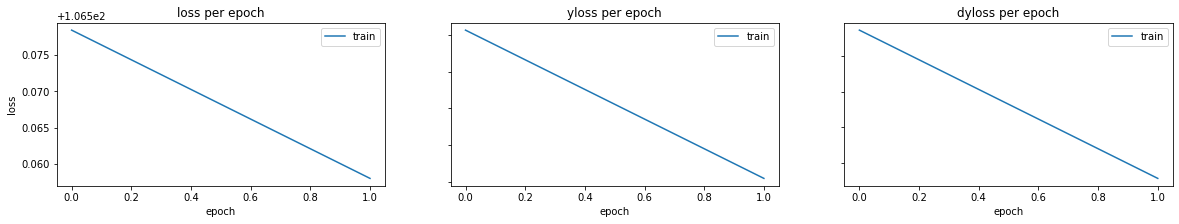

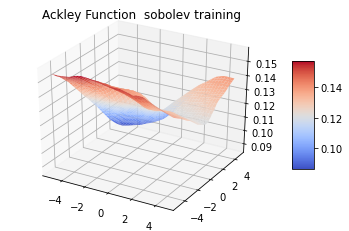

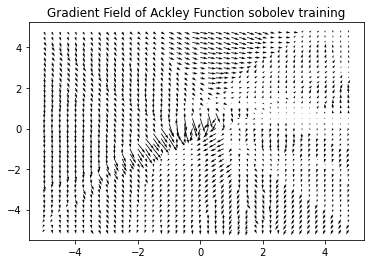

In [81]:
with_derivative = True
name_function = 'Ackley Function  sobolev training'
name_grad = 'Gradient Field of Ackley Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **2.3) Siren**

Epoch 0: train loss: 109.368896484375, y loss : 100.8834457397461, dy loss : 8.48544979095459
Epoch 1: train loss: 108.99958801269531, y loss : 100.7796859741211, dy loss : 8.219902992248535
test loss: 96.31692504882812, y loss : 83.38892364501953, dy loss : 12.928004264831543


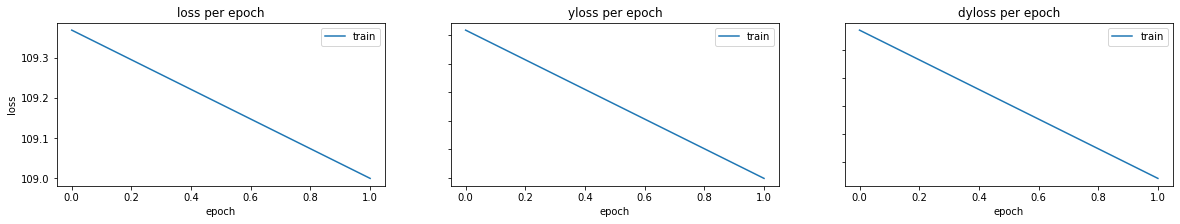

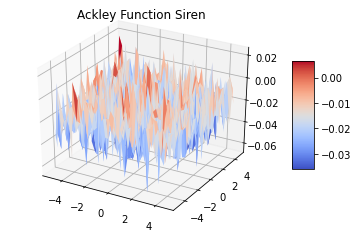

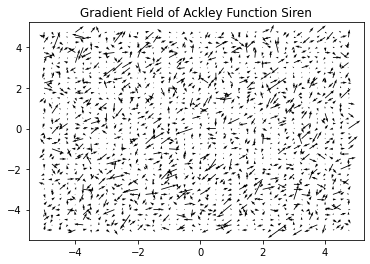

In [82]:
with_derivative = True
name_function = 'Ackley Function Siren'
name_grad = 'Gradient Field of Ackley Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **2.4) Differential ML**

In [83]:
generator = Generator(callable_function = AckleyFunction, callable_function_deriv = AckleyDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Ackley Differential ML"
name_function = 'Ackley Function Differential ML'
name_grad = 'Gradient Field of Ackley Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 23.47208
standard_dyloss : 10.448033
differential_yloss : 20.895348
differential_dyloss : 10.355406
[[23.47208], [10.448033], [20.895348], [10.355406]]


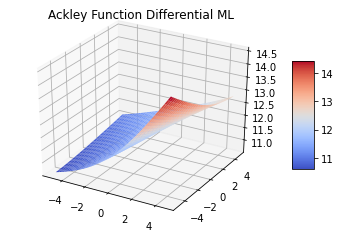

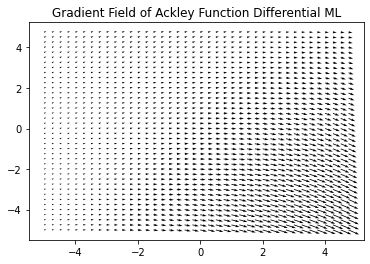

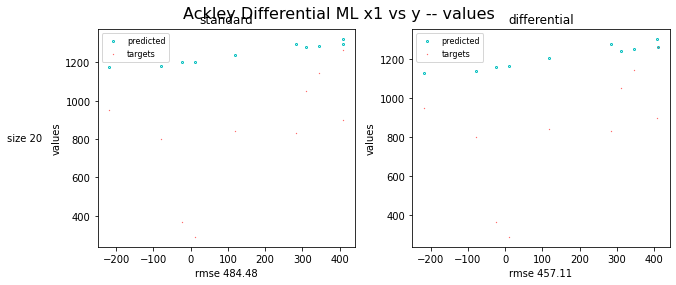

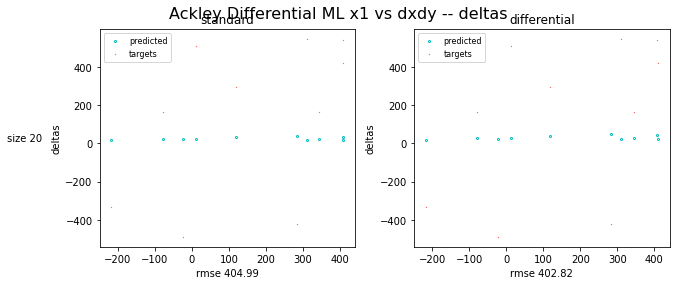

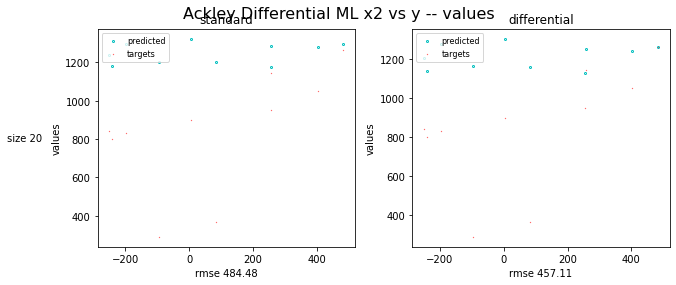

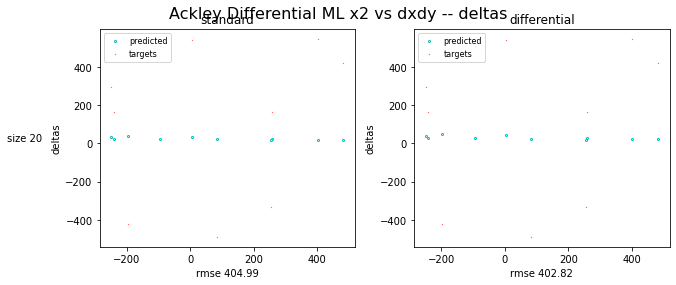

In [84]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 285264.7
standard_dyloss : 496047.66
differential_yloss : 214806.7
differential_dyloss : 552278.9
[[285264.7], [496047.66], [214806.7], [552278.9]]


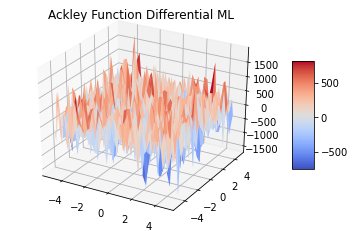

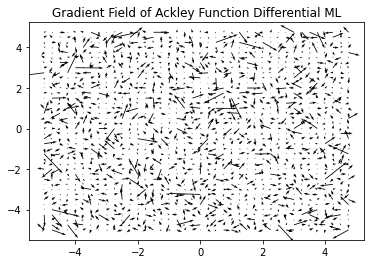

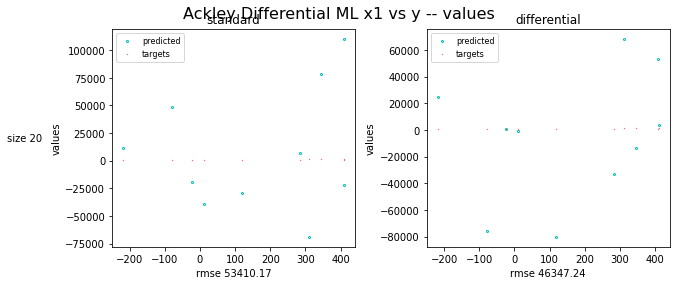

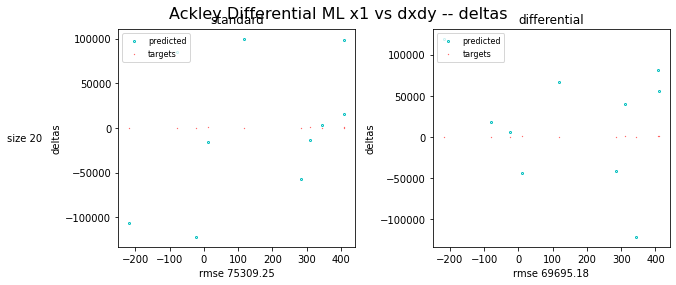

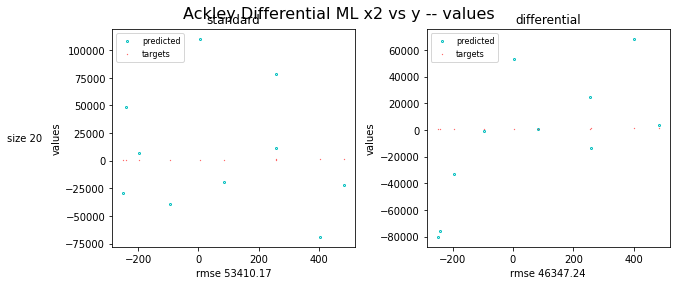

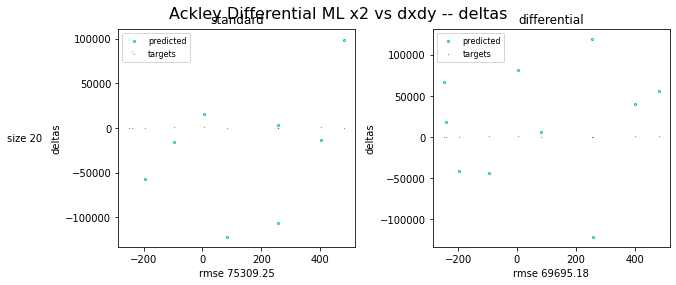

In [85]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **2.5) twin_net with siren**

Epoch 0: train loss: 177.44801330566406, y loss : 87.36392211914062, dy loss : 90.08409118652344
train loss no scaled: 177.44801330566406, y loss  no scaled : 87.36392211914062, dy loss  no scaled: 90.08409118652344
Epoch 1: train loss: 137.22482299804688, y loss : 86.57469940185547, dy loss : 50.65011978149414
train loss no scaled: 137.2248191833496, y loss  no scaled : 86.57469940185547, dy loss  no scaled: 50.65011978149414

test loss: 141.6702117919922, y loss : 72.152099609375, dy loss : 69.51811218261719
test loss no scaled: 141.6702117919922, y loss  no scaled : 72.152099609375, dy loss  no scaled: 69.51811218261719


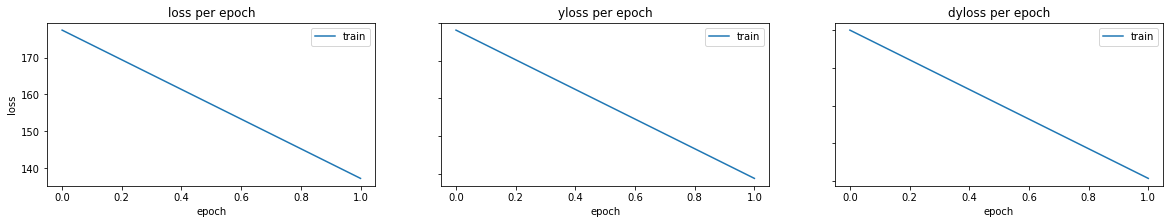

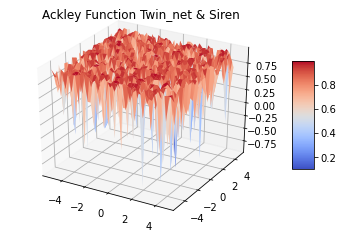

In [86]:
with_derivative = True      
name_function = 'Ackley Function Twin_net & Siren'
name_grad = 'Gradient Field of Ackley Function Twin_net & Siren'

twinNet, test_loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **2.6) twin_net with MLP**

Epoch 0: train loss: 92.25325775146484, y loss : 83.61516571044922, dy loss : 8.638090133666992
train loss no scaled: 92.25325584411621, y loss  no scaled : 83.61516571044922, dy loss  no scaled: 8.638090133666992
Epoch 1: train loss: 92.20865631103516, y loss : 83.5705795288086, dy loss : 8.638075828552246
train loss no scaled: 92.20865535736084, y loss  no scaled : 83.5705795288086, dy loss  no scaled: 8.638075828552246

test loss: 80.75092315673828, y loss : 68.41799926757812, dy loss : 12.33292293548584
test loss no scaled: 80.75092220306396, y loss  no scaled : 68.41799926757812, dy loss  no scaled: 12.33292293548584


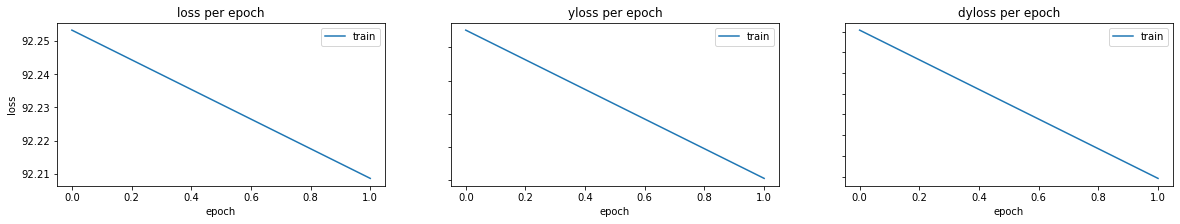

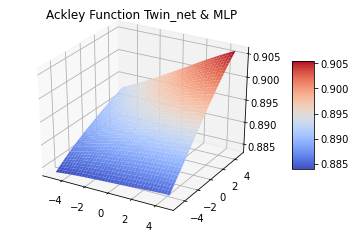

In [87]:
with_derivative = True      
name_function = 'Ackley Function Twin_net & MLP'
name_grad = 'Gradient Field of Ackley Function Twin_net & MLP'

twinNet, test_loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **3) Beale function** : https://www.sfu.ca/~ssurjano/beale.html


In [88]:
min_x = -4.5
max_x = 4.5
step_x = 0.25
min_y = -4.5
max_y = 4.5
step_y = 0.25

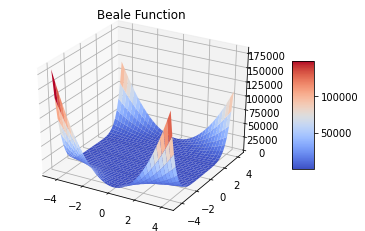

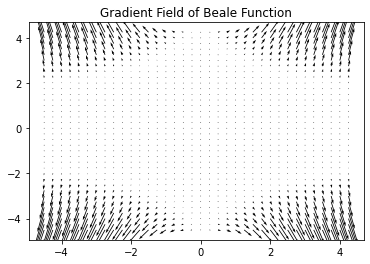

In [89]:
plotFunction(name = 'Beale Function', function = BealeFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Beale Function', deriv_function = BealeDeriv, 
            min_x = min_x, max_x = max_x, step_x = step_x, 
            min_y = min_y, max_y = max_y, step_y = step_y)

In [90]:
batch_samples = genData(
                        function = BealeFunction, 
                        deriv_function = BealeDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BealeFunction, 
                        deriv_function = BealeDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **3.1) Normal Training**

Epoch 0: train loss: 362958528.0
Epoch 1: train loss: 362958528.0
test loss: 28802716.0


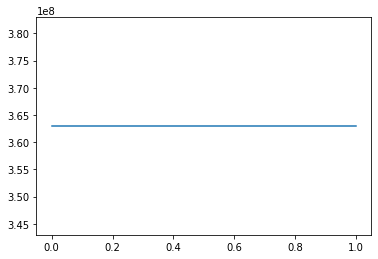

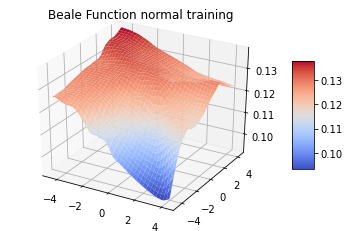

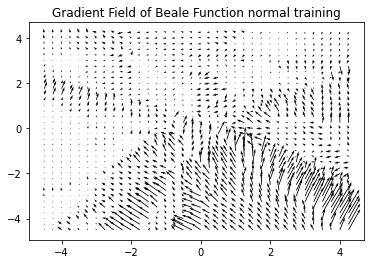

In [91]:
with_derivative = False
name_function = 'Beale Function normal training'
name_grad = 'Gradient Field of Beale Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **3.2) Sobolev Training**

Epoch 0: train loss: 790493888.0, y loss : 362959488.0, dy loss : 427534400.0
Epoch 1: train loss: 790493824.0, y loss : 362959456.0, dy loss : 427534400.0
test loss: 84153128.0, y loss : 28803168.0, dy loss : 55349960.0


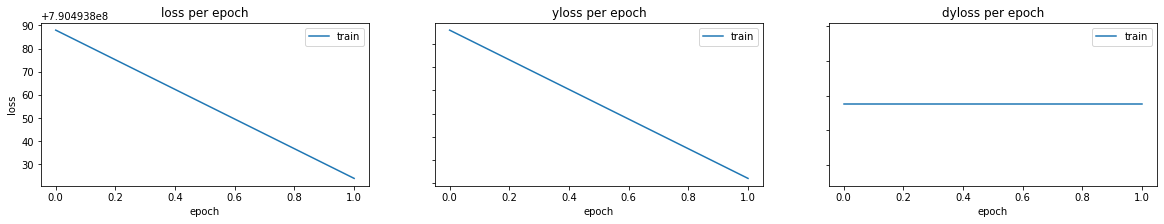

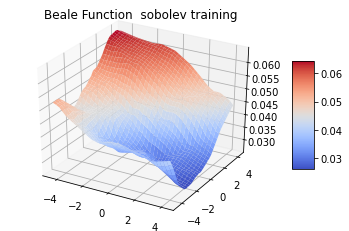

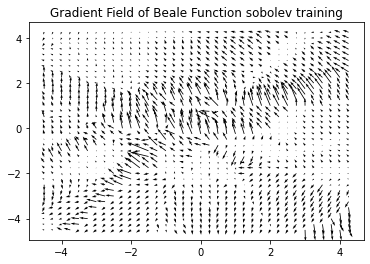

In [92]:
with_derivative = True
name_function = 'Beale Function  sobolev training'
name_grad = 'Gradient Field of Beale Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **3.3) Siren**

Epoch 0: train loss: 790494912.0, y loss : 362958848.0, dy loss : 427536064.0
Epoch 1: train loss: 790492672.0, y loss : 362958848.0, dy loss : 427533824.0
test loss: 84151848.0, y loss : 28802778.0, dy loss : 55349068.0


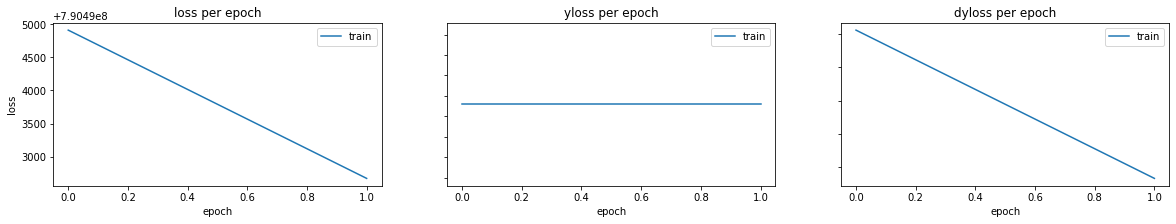

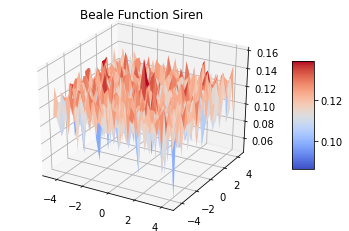

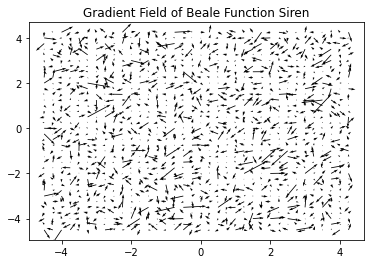

In [93]:
with_derivative = True
name_function = 'Beale Function Siren'
name_grad = 'Gradient Field of Beale Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **3.4) Differential ML**

In [94]:
generator = Generator(callable_function = BealeFunction, callable_function_deriv = BealeDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Beale Differential ML"
name_function = 'Beale Function Differential ML'
name_grad = 'Gradient Field of Beale Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 697314370.0
standard_dyloss : 1008910500.0
differential_yloss : 687011800.0
differential_dyloss : 1009893500.0
[[697314370.0], [1008910500.0], [687011800.0], [1009893500.0]]


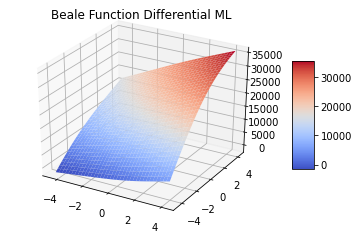

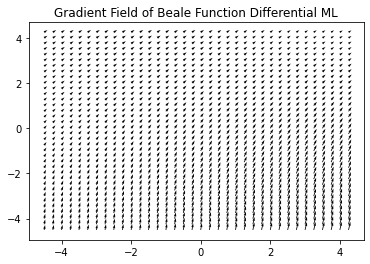

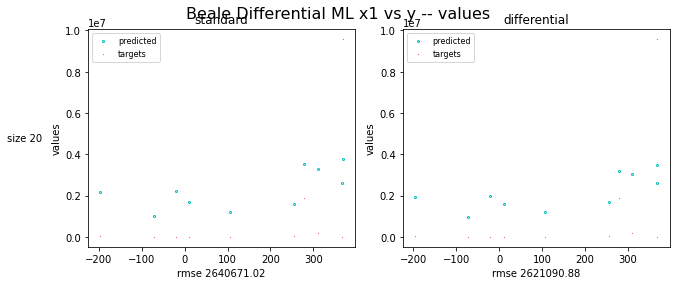

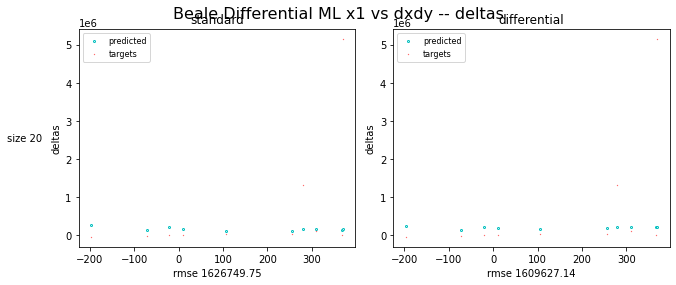

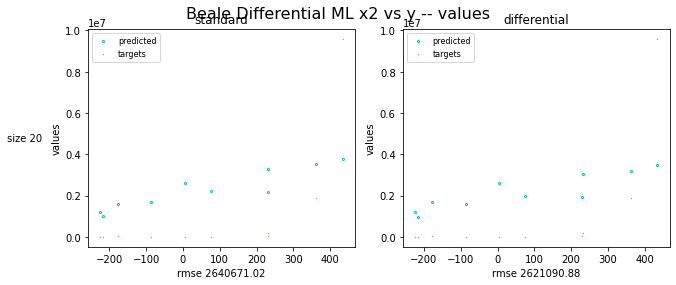

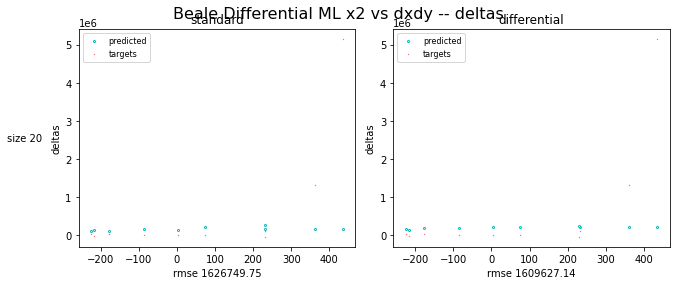

In [95]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 22449576000000.0
standard_dyloss : 128753840000000.0
differential_yloss : 19891240000000.0
differential_dyloss : 43013456000000.0
[[22449576000000.0], [128753840000000.0], [19891240000000.0], [43013456000000.0]]


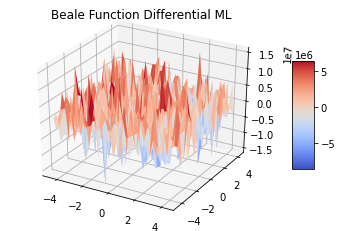

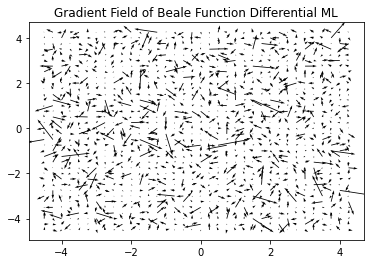

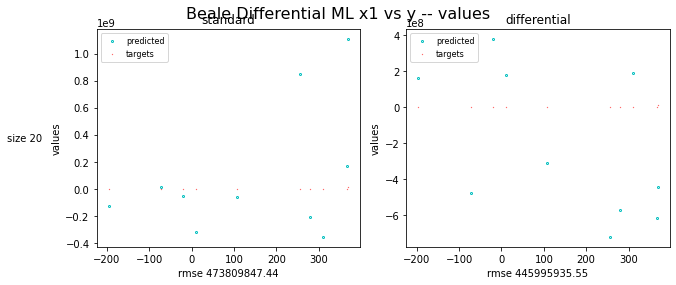

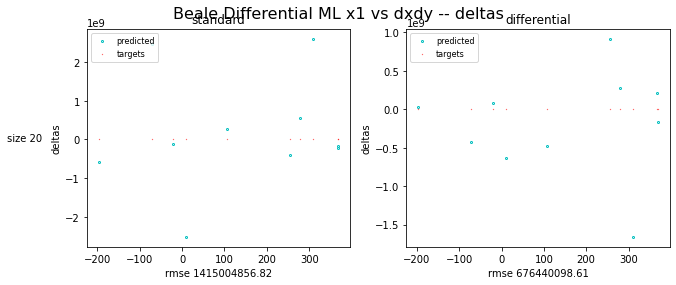

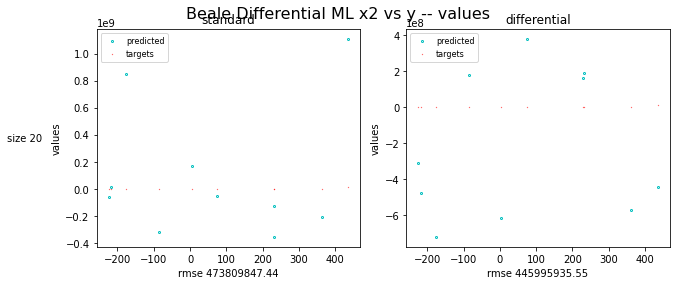

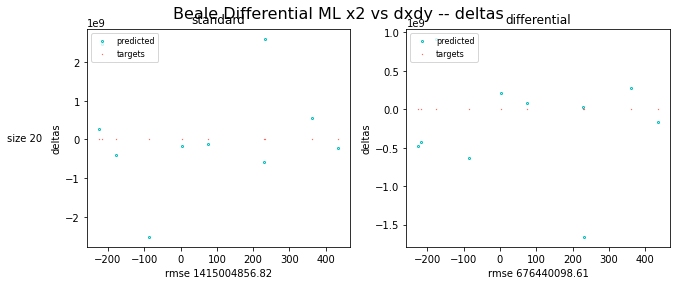

In [96]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **3.5) twin_net with siren**

Epoch 0: train loss: 790504576.0, y loss : 362951840.0, dy loss : 427552704.0
train loss no scaled: 790504544.0, y loss  no scaled : 362951840.0, dy loss  no scaled: 427552704.0
Epoch 1: train loss: 790434880.0, y loss : 362950208.0, dy loss : 427484672.0
train loss no scaled: 790434880.0, y loss  no scaled : 362950208.0, dy loss  no scaled: 427484672.0

test loss: 84155104.0, y loss : 28799316.0, dy loss : 55355784.0
test loss no scaled: 84155100.0, y loss  no scaled : 28799316.0, dy loss  no scaled: 55355784.0


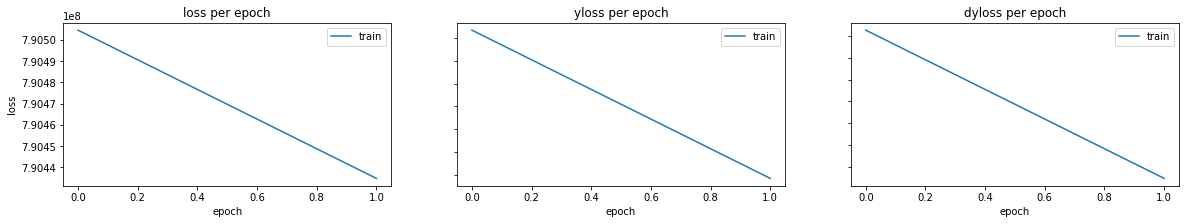

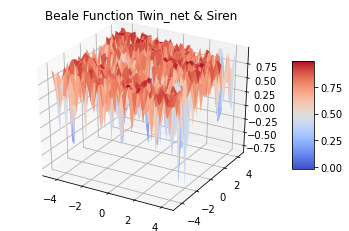

In [97]:
with_derivative = True      
name_function = 'Beale Function Twin_net & Siren'
name_grad = 'Gradient Field of Beale Function Twin_net & Siren'

twinNet, test_loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **3.6) twin_net with MLP**

Epoch 0: train loss: 790483456.0, y loss : 362948992.0, dy loss : 427534432.0
train loss no scaled: 790483424.0, y loss  no scaled : 362948992.0, dy loss  no scaled: 427534432.0
Epoch 1: train loss: 790483328.0, y loss : 362948928.0, dy loss : 427534432.0
train loss no scaled: 790483360.0, y loss  no scaled : 362948928.0, dy loss  no scaled: 427534432.0

test loss: 84148168.0, y loss : 28798202.0, dy loss : 55349964.0
test loss no scaled: 84148166.0, y loss  no scaled : 28798202.0, dy loss  no scaled: 55349964.0


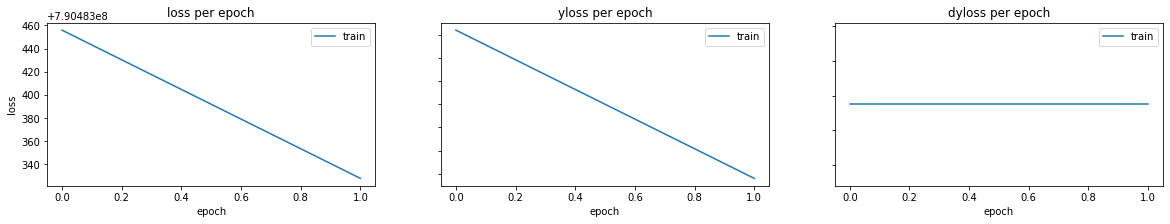

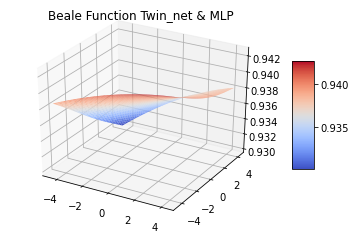

In [98]:
with_derivative = True      
name_function = 'Beale Function Twin_net & MLP'
name_grad = 'Gradient Field of Beale Function Twin_net & MLP'

twinNet, test_loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **4) Booth function** : https://www.sfu.ca/~ssurjano/booth.html

In [99]:
min_x = -10 
max_x = 10
step_x = 0.25
min_y = -10
max_y = 10
step_y = 0.25

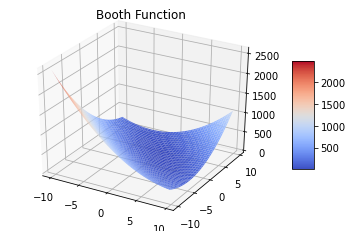

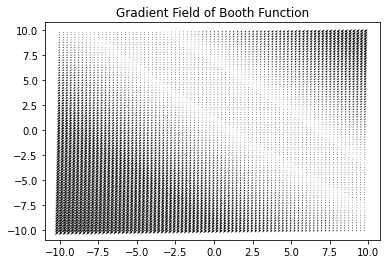

In [100]:
plotFunction(name = 'Booth Function', function = BoothFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Booth Function', deriv_function = BoothDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [101]:
batch_samples = genData(
                        function = BoothFunction, 
                        deriv_function = BoothDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BoothFunction, 
                        deriv_function = BoothDeriv,
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **4.1) Normal Training**

Epoch 0: train loss: 235464.5
Epoch 1: train loss: 235463.71875
test loss: 270210.5625


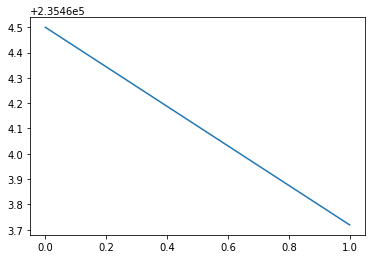

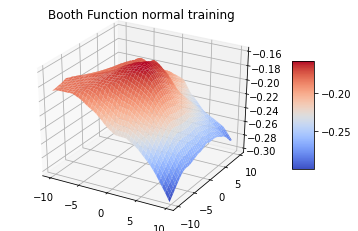

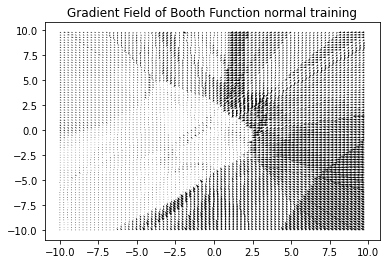

In [102]:
with_derivative = False
name_function = 'Booth Function normal training'
name_grad = 'Gradient Field of Booth Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **4.2) Sobolev Training**

Epoch 0: train loss: 235409.703125
Epoch 1: train loss: 235408.84375
test loss: 270149.0625


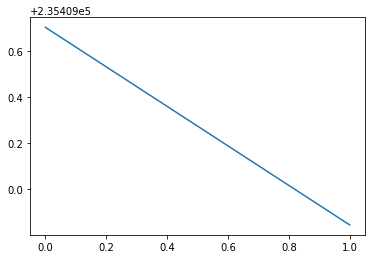

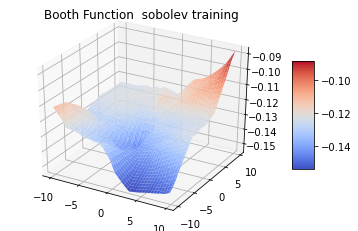

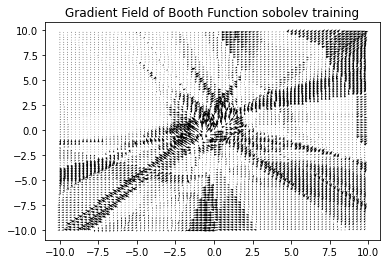

In [103]:
with_derivative = False
name_function = 'Booth Function  sobolev training'
name_grad = 'Gradient Field of Booth Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **4.3) Siren**

Epoch 0: train loss: 240687.3125, y loss : 235301.84375, dy loss : 5385.466796875
Epoch 1: train loss: 240675.46875, y loss : 235297.953125, dy loss : 5377.5107421875
test loss: 276357.90625, y loss : 270032.65625, dy loss : 6325.24462890625


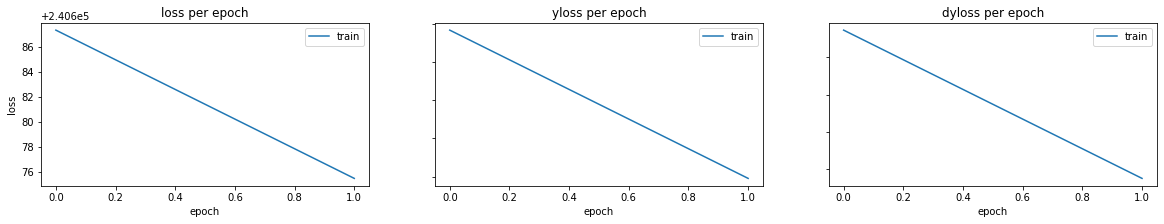

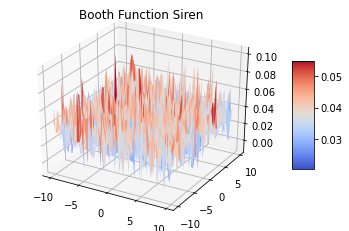

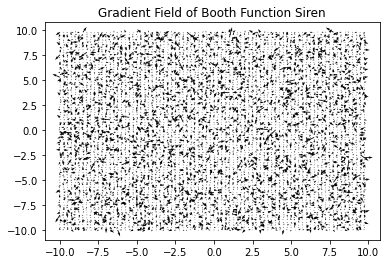

In [104]:
with_derivative = True
name_function = 'Booth Function Siren'
name_grad = 'Gradient Field of Booth Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **4.4) Differential ML**

In [105]:
generator = Generator(callable_function = BoothFunction, callable_function_deriv = BoothDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Booth Differential ML"
name_function = 'Booth Function Differential ML'
name_grad = 'Gradient Field of Booth Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 271176.7
standard_dyloss : 4748.9194
differential_yloss : 181784.5
differential_dyloss : 4600.2095
[[271176.7], [4748.9194], [181784.5], [4600.2095]]


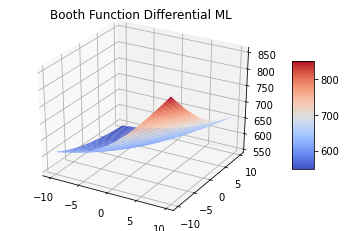

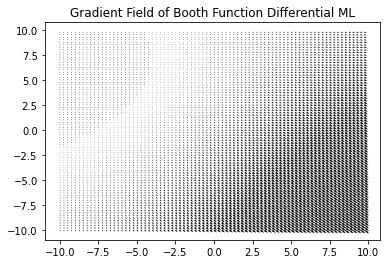

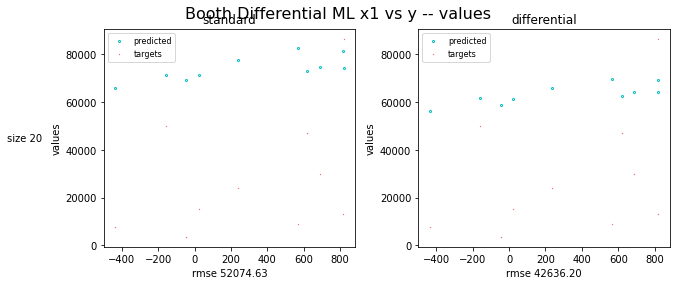

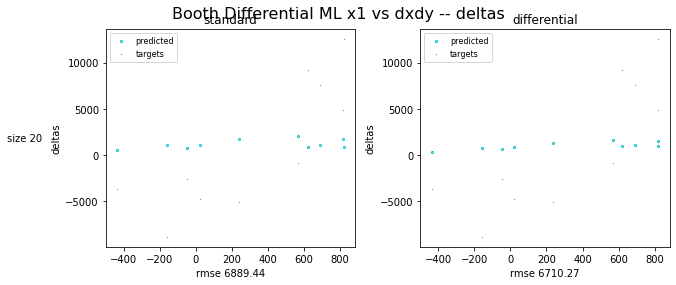

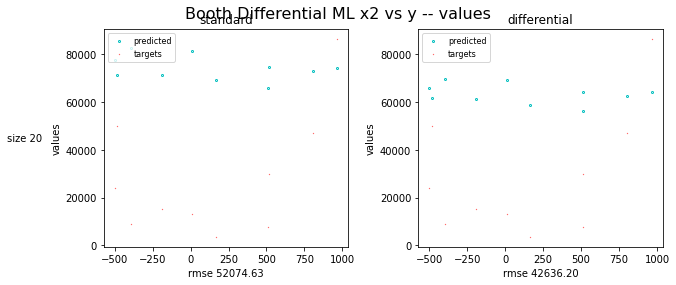

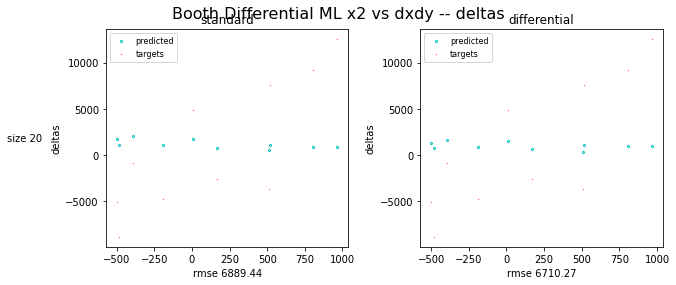

In [106]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 1778869000.0
standard_dyloss : 2843188000.0
differential_yloss : 2776521500.0
differential_dyloss : 892322800.0
[[1778869000.0], [2843188000.0], [2776521500.0], [892322800.0]]


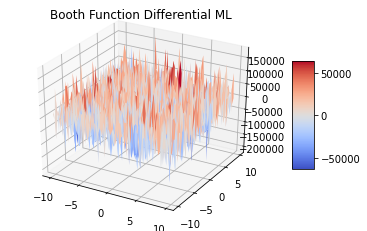

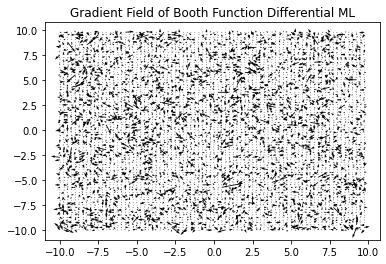

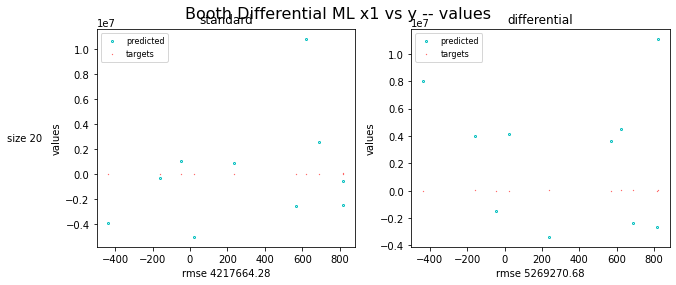

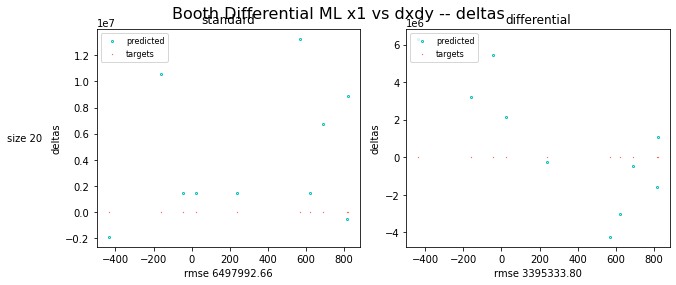

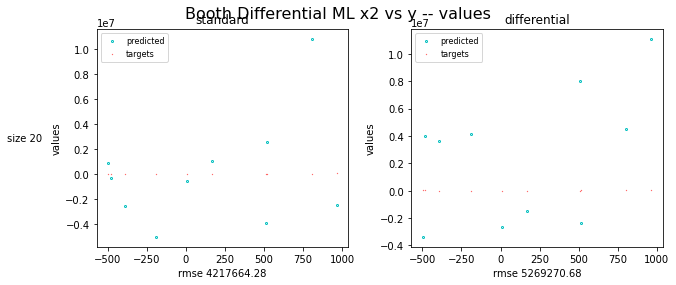

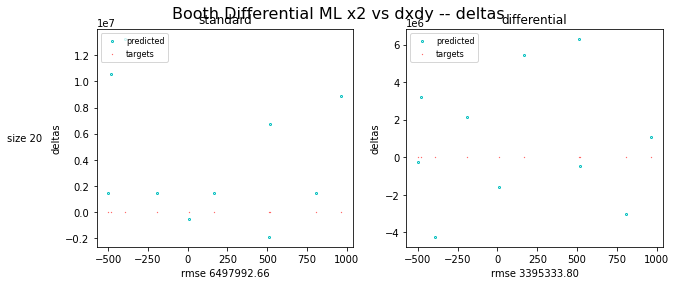

In [107]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **4.5) twin_net with siren**

Epoch 0: train loss: 241456.734375, y loss : 235874.125, dy loss : 5582.6162109375
train loss no scaled: 241456.7412109375, y loss  no scaled : 235874.125, dy loss  no scaled: 5582.6162109375
Epoch 1: train loss: 241240.078125, y loss : 235669.53125, dy loss : 5570.54345703125
train loss no scaled: 241240.07470703125, y loss  no scaled : 235669.53125, dy loss  no scaled: 5570.54345703125

test loss: 276243.5625, y loss : 270551.1875, dy loss : 5692.3642578125
test loss no scaled: 276243.5517578125, y loss  no scaled : 270551.1875, dy loss  no scaled: 5692.3642578125


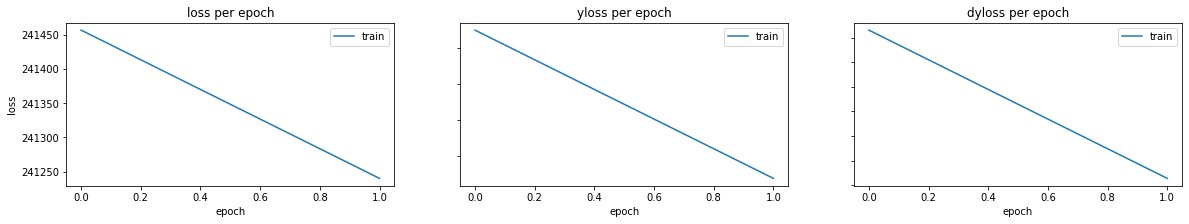

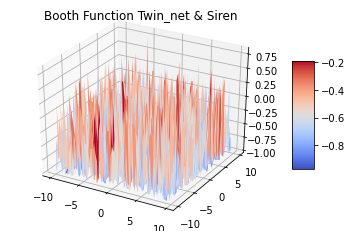

In [108]:
with_derivative = True      
name_function = 'Booth Function Twin_net & Siren'
name_grad = 'Gradient Field of Booth Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **4.6) twin_net with MLP**

Epoch 0: train loss: 240303.234375, y loss : 234921.25, dy loss : 5381.9892578125
train loss no scaled: 240303.2392578125, y loss  no scaled : 234921.25, dy loss  no scaled: 5381.9892578125
Epoch 1: train loss: 240302.234375, y loss : 234920.25, dy loss : 5381.98779296875
train loss no scaled: 240302.23779296875, y loss  no scaled : 234920.25, dy loss  no scaled: 5381.98779296875

test loss: 275923.4375, y loss : 269599.9375, dy loss : 6323.5146484375
test loss no scaled: 275923.4521484375, y loss  no scaled : 269599.9375, dy loss  no scaled: 6323.5146484375


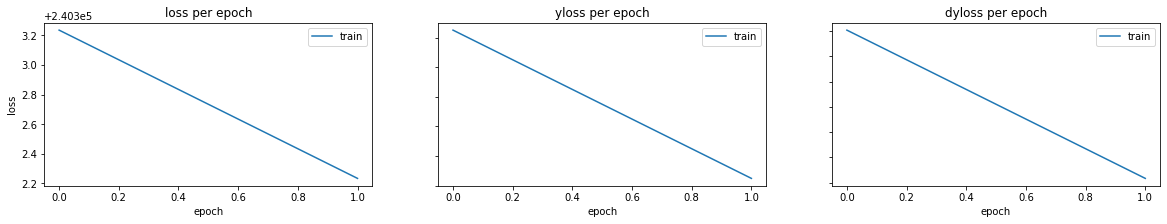

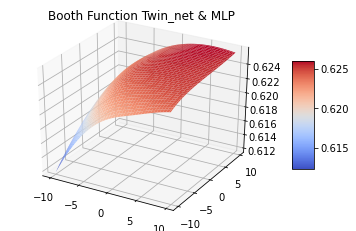

In [109]:
with_derivative = True      
name_function = 'Booth Function Twin_net & MLP'
name_grad = 'Gradient Field of Booth Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **5) Bukin function** : https://www.sfu.ca/~ssurjano/bukin6.html


In [110]:
min_x = -15
max_x = -5
step_x = 0.25
min_y = -3
max_y = 3
step_y = 0.25

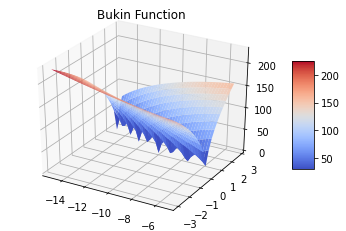

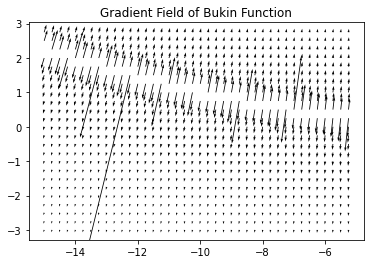

In [111]:
plotFunction(name = 'Bukin Function', function = BukinFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Bukin Function', deriv_function = BukinDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [112]:
batch_samples = genData(
                        function = BukinFunction, 
                        deriv_function = BukinDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = BukinFunction, 
                        deriv_function = BukinDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **5.1) Normal Training**

Epoch 0: train loss: 102103.40625
Epoch 1: train loss: 102102.75
test loss: 108437.453125


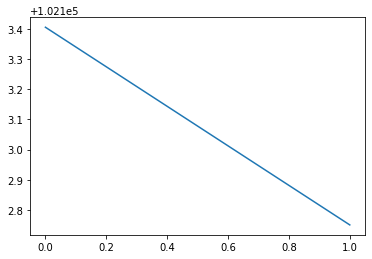

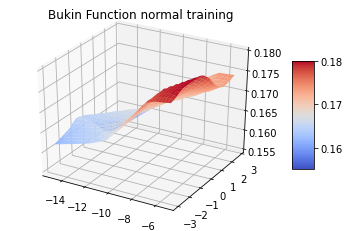

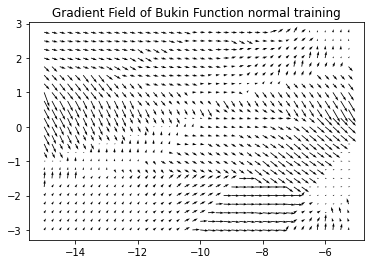

In [113]:
with_derivative = False
name_function = 'Bukin Function normal training'
name_grad = 'Gradient Field of Bukin Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **5.2) Sobolev Training**

Epoch 0: train loss: 102151.390625, y loss : 102013.84375, dy loss : 137.5472412109375
Epoch 1: train loss: 102150.6015625, y loss : 102013.0546875, dy loss : 137.54798889160156
test loss: 108480.1015625, y loss : 108352.921875, dy loss : 127.17942810058594


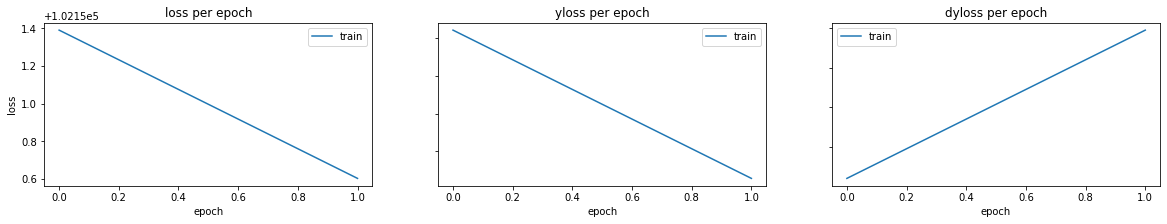

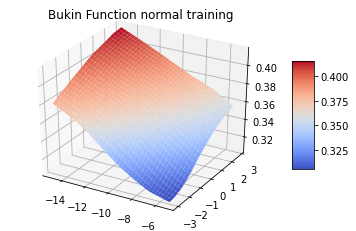

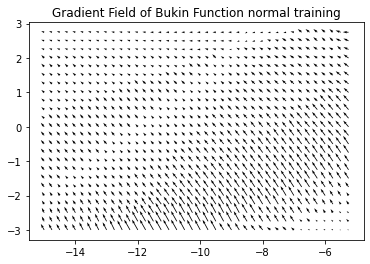

In [114]:
with_derivative = True
name_function = 'Bukin Function normal training'
name_grad = 'Gradient Field of Bukin Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **5.3) Siren**

Epoch 0: train loss: 102358.65625, y loss : 102219.34375, dy loss : 139.31573486328125
Epoch 1: train loss: 102351.484375, y loss : 102212.6328125, dy loss : 138.85113525390625
test loss: 108671.921875, y loss : 108542.8359375, dy loss : 129.0893096923828


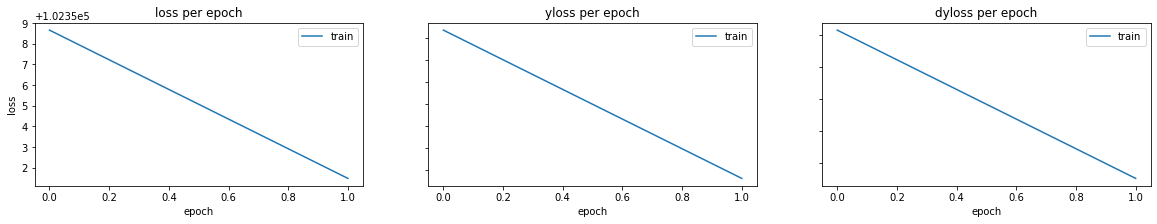

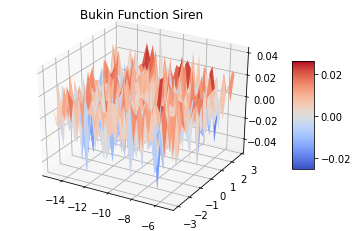

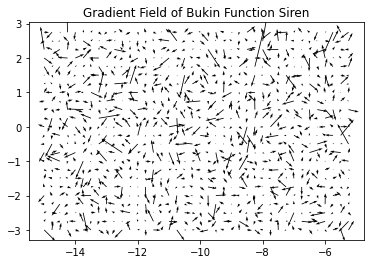

In [115]:
with_derivative = True
name_function = 'Bukin Function Siren'
name_grad = 'Gradient Field of Bukin Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **5.4) Differential ML**

In [116]:
generator = Generator(callable_function = BukinFunction, callable_function_deriv = BukinDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Bukin Differential ML"
name_function = 'Bukin Function Differential ML'
name_grad = 'Gradient Field of Bukin Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 1713.9431
standard_dyloss : 72.50551
differential_yloss : 1822.9717
differential_dyloss : 136.89754
[[1713.9431], [72.50551], [1822.9717], [136.89754]]


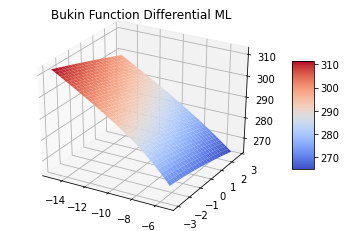

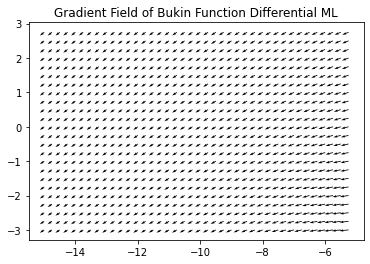

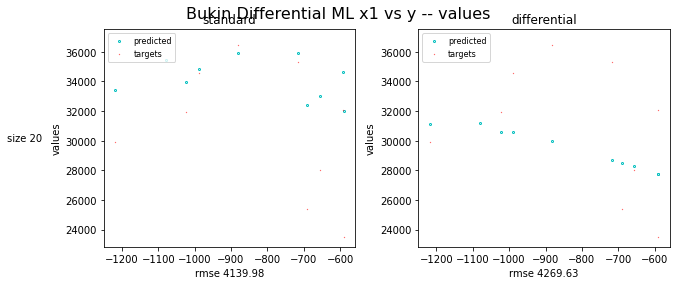

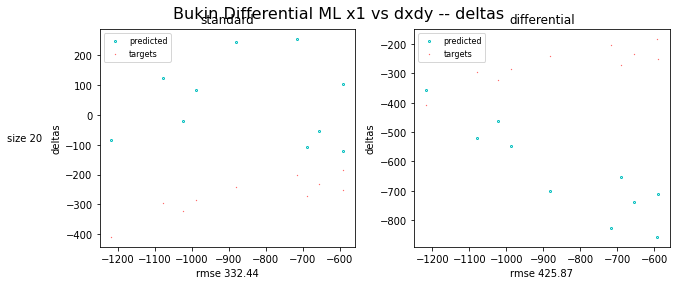

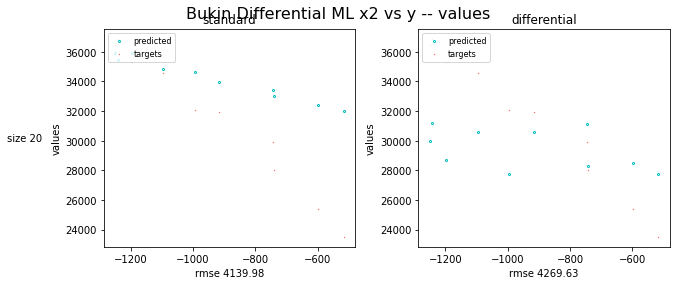

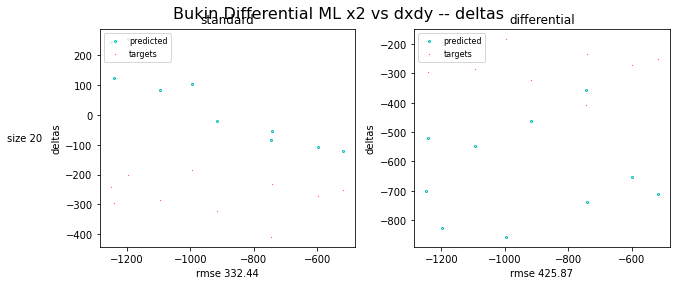

In [117]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 88311880.0
standard_dyloss : 465011780.0
differential_yloss : 50674730.0
differential_dyloss : 109418540.0
[[88311880.0], [465011780.0], [50674730.0], [109418540.0]]


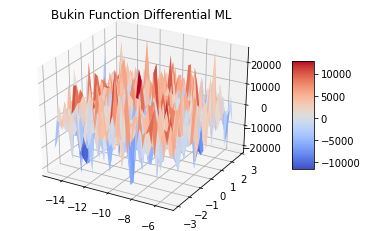

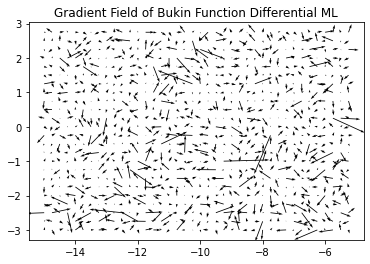

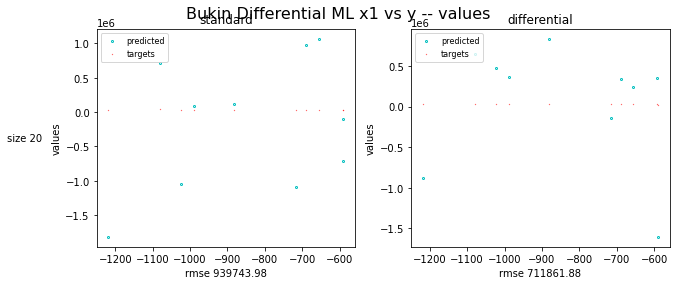

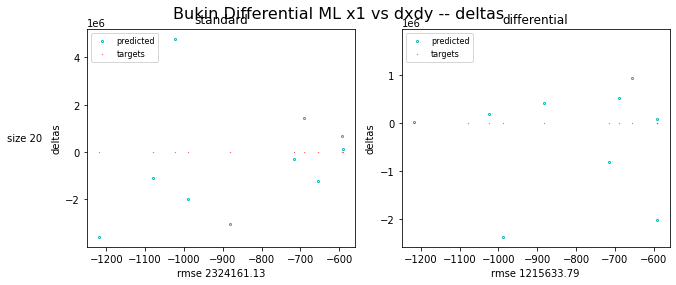

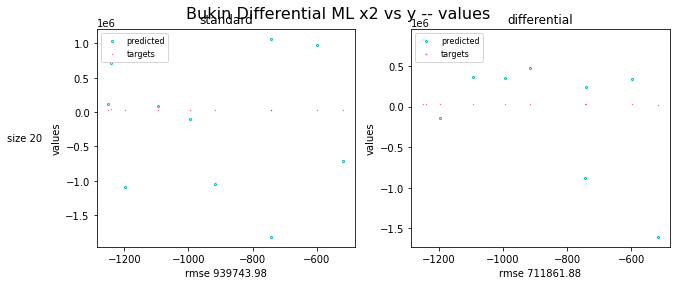

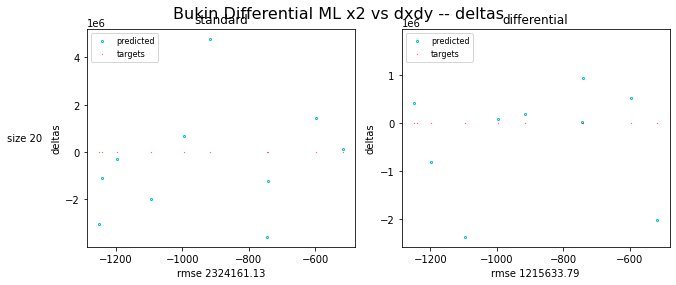

In [118]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **5.5) twin_net with siren**

Epoch 0: train loss: 102923.6875, y loss : 102678.0, dy loss : 245.6905975341797
train loss no scaled: 102923.69059753418, y loss  no scaled : 102678.0, dy loss  no scaled: 245.6905975341797
Epoch 1: train loss: 102977.2265625, y loss : 102704.5625, dy loss : 272.6672668457031
train loss no scaled: 102977.2297668457, y loss  no scaled : 102704.5625, dy loss  no scaled: 272.6672668457031
test loss: 109065.0625, y loss : 108913.171875, dy loss : 151.89393615722656
test loss no scaled: 109065.06581115723, y loss  no scaled : 108913.171875, dy loss  no scaled: 151.89393615722656



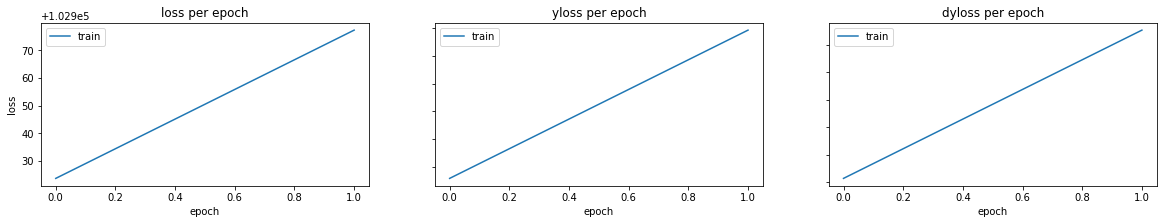

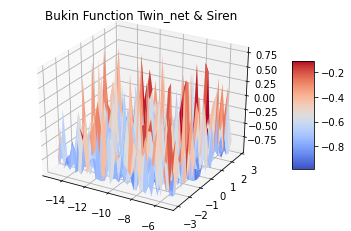

In [119]:
with_derivative = True      
name_function = 'Bukin Function Twin_net & Siren'
name_grad = 'Gradient Field of Bukin Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **5.6) twin_net with MLP**

Epoch 0: train loss: 101896.671875, y loss : 101759.171875, dy loss : 137.50350952148438
train loss no scaled: 101896.67538452148, y loss  no scaled : 101759.171875, dy loss  no scaled: 137.50350952148438
Epoch 1: train loss: 101895.390625, y loss : 101757.890625, dy loss : 137.50302124023438
train loss no scaled: 101895.39364624023, y loss  no scaled : 101757.890625, dy loss  no scaled: 137.50302124023438

test loss: 108207.7890625, y loss : 108080.6484375, dy loss : 127.13720703125
test loss no scaled: 108207.78564453125, y loss  no scaled : 108080.6484375, dy loss  no scaled: 127.13720703125


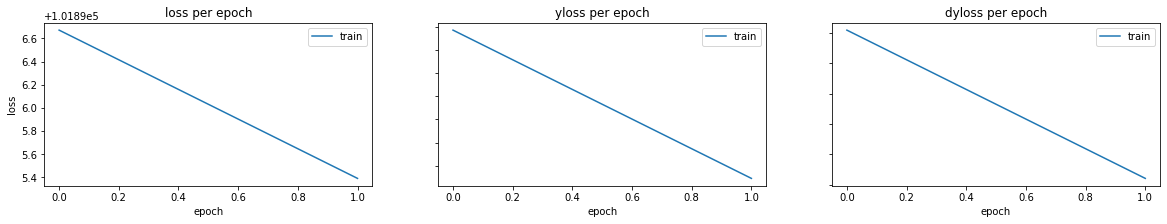

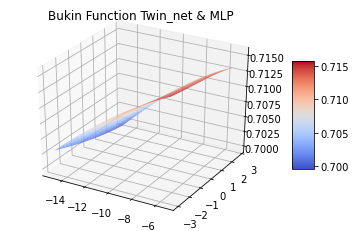

In [120]:
with_derivative = True      
name_function = 'Bukin Function Twin_net & MLP'
name_grad = 'Gradient Field of Bukin Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **6) McCormick function** : https://www.sfu.ca/~ssurjano/mccorm.html

In [121]:
min_x = -1.5
max_x = 4
step_x = 0.25
min_y = -3
max_y = 4
step_y = 0.25

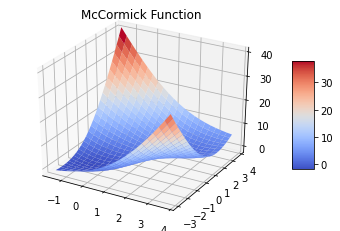

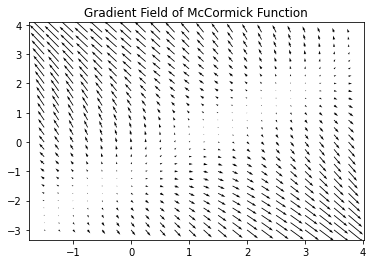

In [122]:
plotFunction(name = 'McCormick Function', function = McCormickFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of McCormick Function', deriv_function = McCormickDeriv, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

In [123]:
batch_samples = genData(
                        function = McCormickFunction, 
                        deriv_function = McCormickDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = McCormickFunction, 
                        deriv_function = McCormickDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **6.1) Normal Training**

Epoch 0: train loss: 119.66358947753906
Epoch 1: train loss: 119.65083312988281
test loss: 7.999027252197266


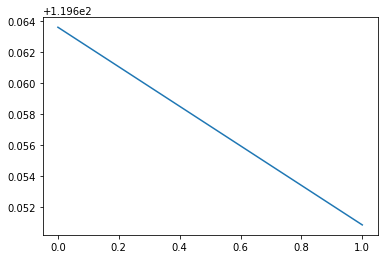

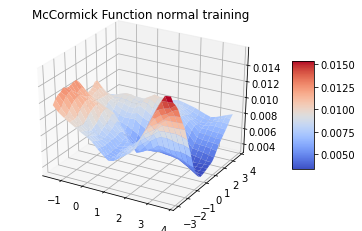

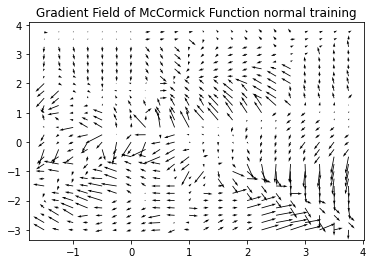

In [124]:
with_derivative = False
name_function = 'McCormick Function normal training'
name_grad = 'Gradient Field of McCormick Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **6.2) Sobolev Training**

Epoch 0: train loss: 125.56571960449219
Epoch 1: train loss: 125.54593658447266
test loss: 9.750558853149414


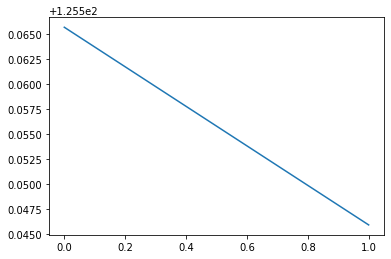

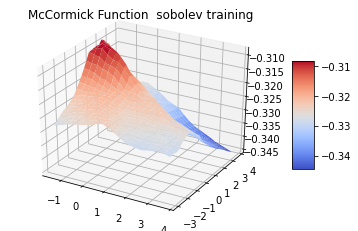

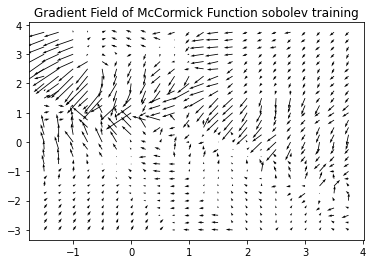

In [125]:
with_derivative = False
name_function = 'McCormick Function  sobolev training'
name_grad = 'Gradient Field of McCormick Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **6.3) Siren**

Epoch 0: train loss: 151.1444091796875, y loss : 120.2459716796875, dy loss : 30.898441314697266
Epoch 1: train loss: 150.4190216064453, y loss : 120.18428802490234, dy loss : 30.2347354888916
test loss: 11.87940788269043, y loss : 8.10676383972168, dy loss : 3.772644519805908


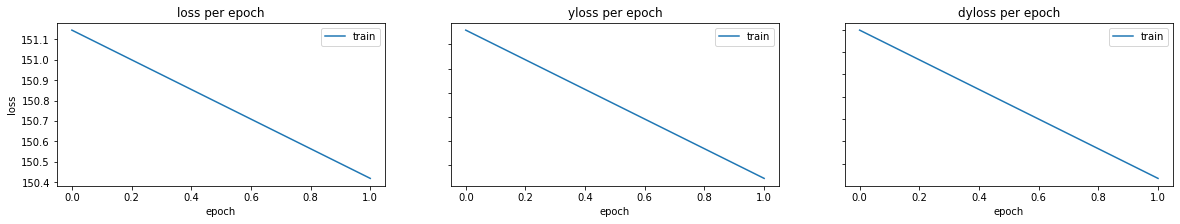

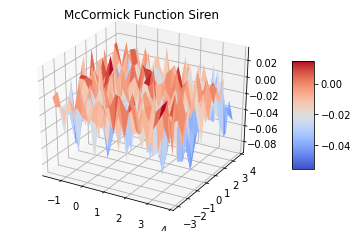

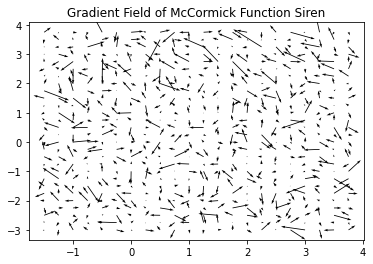

In [126]:
with_derivative = True
name_function = 'McCormick Function Siren'
name_grad = 'Gradient Field of McCormick Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **6.4) Differential ML**

In [127]:
generator = Generator(callable_function = McCormickFunction, callable_function_deriv = McCormickDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "McCormick Differential ML"
name_function = 'McCormick Function Differential ML'
name_grad = 'Gradient Field of McCormick Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 20.515202
standard_dyloss : 11.802238
differential_yloss : 27.827606
differential_dyloss : 10.48918
[[20.515202], [11.802238], [27.827606], [10.48918]]


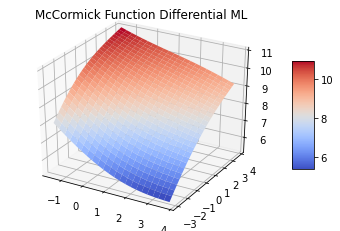

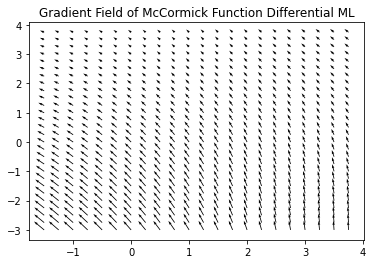

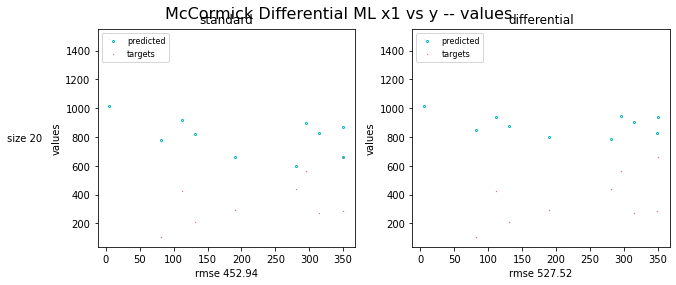

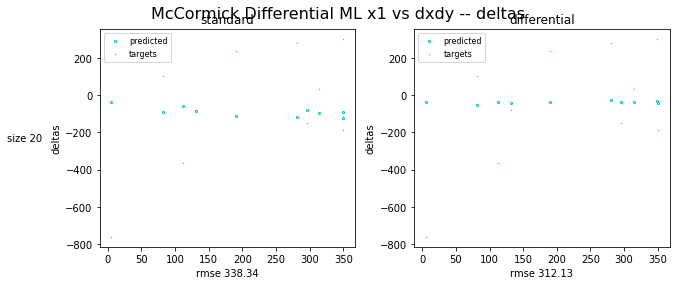

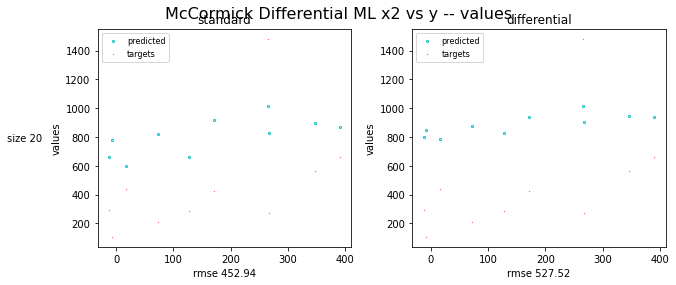

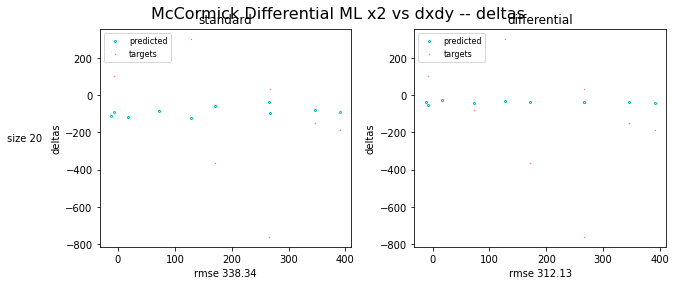

In [128]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 494501.44
standard_dyloss : 8380810.5
differential_yloss : 980322.3
differential_dyloss : 1856987.4
[[494501.44], [8380810.5], [980322.3], [1856987.4]]


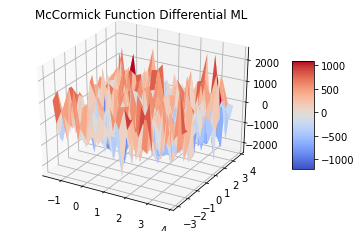

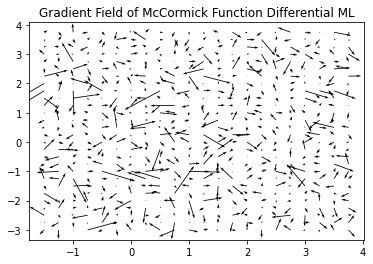

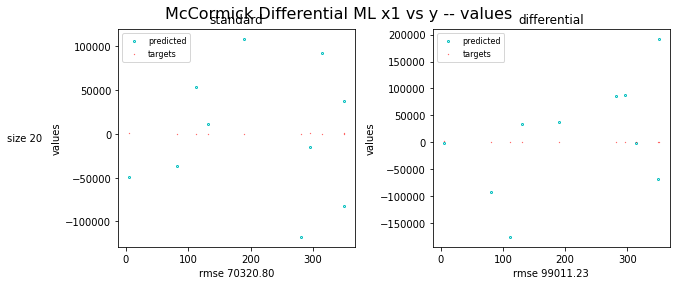

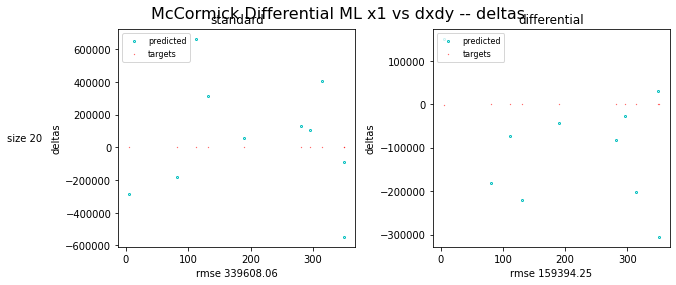

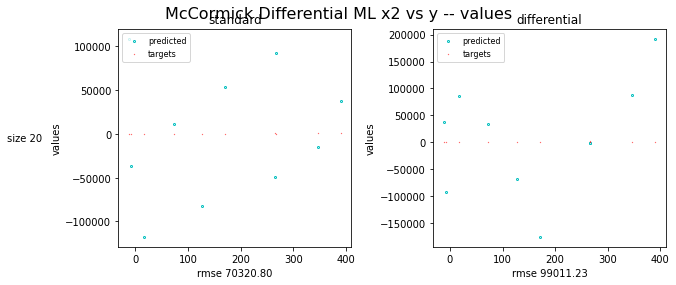

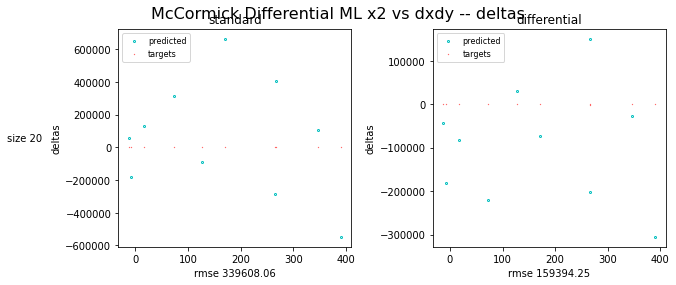

In [129]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **6.5) twin_net with siren**

Epoch 0: train loss: 206.15072631835938, y loss : 126.281005859375, dy loss : 79.86971282958984
train loss no scaled: 206.15071868896484, y loss  no scaled : 126.281005859375, dy loss  no scaled: 79.86971282958984
Epoch 1: train loss: 200.38482666015625, y loss : 116.7364501953125, dy loss : 83.64837646484375
train loss no scaled: 200.38482666015625, y loss  no scaled : 116.7364501953125, dy loss  no scaled: 83.64837646484375

test loss: 65.59236145019531, y loss : 7.41525411605835, dy loss : 58.17710494995117
test loss no scaled: 65.59235906600952, y loss  no scaled : 7.41525411605835, dy loss  no scaled: 58.17710494995117


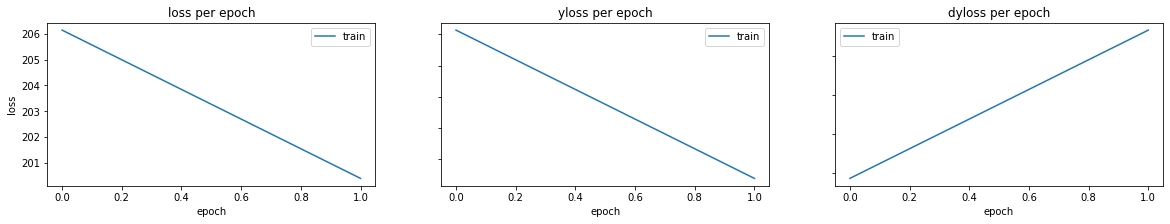

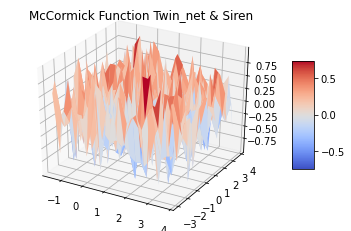

In [130]:
with_derivative = True      
name_function = 'McCormick Function Twin_net & Siren'
name_grad = 'Gradient Field of McCormick Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **6.6) twin_net with MLP**

Epoch 0: train loss: 132.44631958007812, y loss : 102.19995880126953, dy loss : 30.24636459350586
train loss no scaled: 132.4463233947754, y loss  no scaled : 102.19995880126953, dy loss  no scaled: 30.24636459350586
Epoch 1: train loss: 132.3993377685547, y loss : 102.15316009521484, dy loss : 30.24618148803711
train loss no scaled: 132.39934158325195, y loss  no scaled : 102.15316009521484, dy loss  no scaled: 30.24618148803711

test loss: 8.31724739074707, y loss : 3.976372241973877, dy loss : 4.340874671936035
test loss no scaled: 8.317246913909912, y loss  no scaled : 3.976372241973877, dy loss  no scaled: 4.340874671936035


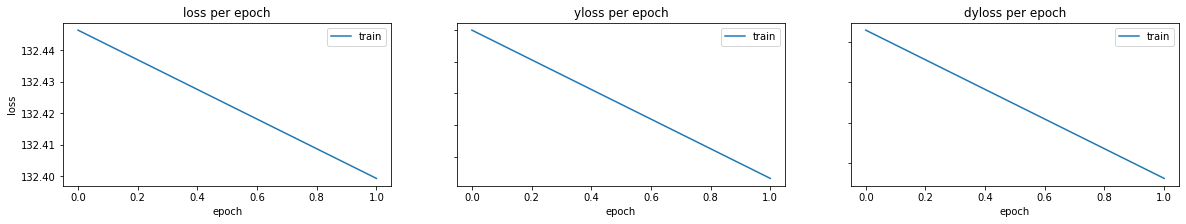

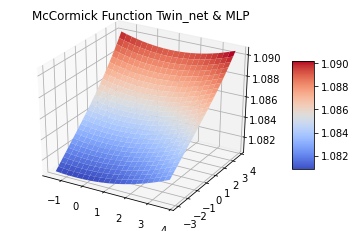

In [131]:
with_derivative = True      
name_function = 'McCormick Function Twin_net & MLP'
name_grad = 'Gradient Field of McCormick Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

# **7) Rosenbrock function** : https://www.sfu.ca/~ssurjano/mccorm.html

In [132]:
min_x = -2 
max_x = 2
step_x = 0.25
min_y = -2 
max_y = 2 
step_y = 0.25

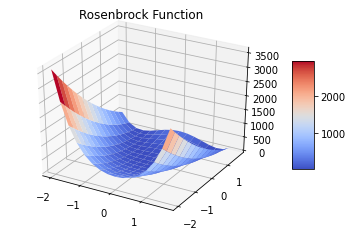

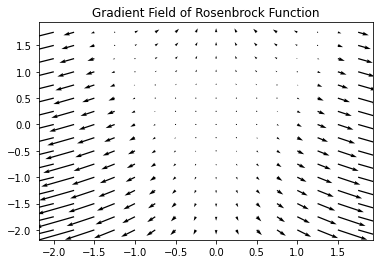

In [133]:
plotFunction(name = 'Rosenbrock Function', function = RosenbrockFunction, 
             min_x = min_x, max_x = max_x, step_x = step_x, 
             min_y = min_y, max_y = max_y, step_y = step_y)

plotGrad(name = 'Gradient Field of Rosenbrock Function', deriv_function = RosenbrockDeriv, 
         min_x = min_x, max_x = max_x, step_x = step_x, 
         min_y = min_y, max_y = max_y, step_y = step_y)

In [134]:
batch_samples = genData(
                        function = RosenbrockFunction, 
                        deriv_function = RosenbrockDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTrain
                )

x_train = [bs[0] for bs in batch_samples]
y_train = [bs[1] for bs in batch_samples]
dydx_train = [bs[2] for bs in batch_samples]

batch_samples = genData(
                        function = RosenbrockFunction, 
                        deriv_function = RosenbrockDeriv, 
                        min_x = min_x, max_x = max_x, num_samples = nTest
                )

x_test = [bs[0] for bs in batch_samples]
y_test = [bs[1] for bs in batch_samples]
dydx_test = [bs[2] for bs in batch_samples]

## **7.1) Normal Training**

Epoch 0: train loss: 305015.84375
Epoch 1: train loss: 305015.1875
test loss: 163876.3125


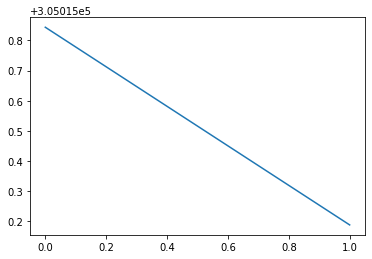

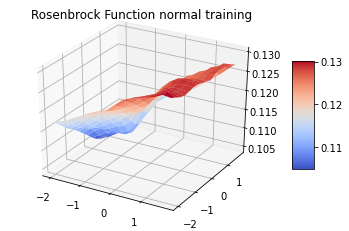

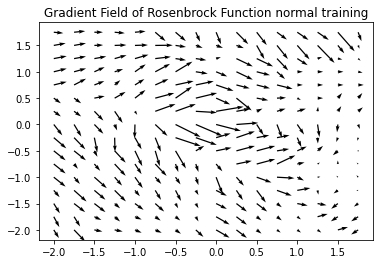

In [135]:
with_derivative = False
name_function = 'Rosenbrock Function normal training'
name_grad = 'Gradient Field of Rosenbrock Function normal training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **7.2) Sobolev Training**

Epoch 0: train loss: 994768.75, y loss : 305073.5, dy loss : 689695.25
Epoch 1: train loss: 994768.0625, y loss : 305072.875, dy loss : 689695.1875
test loss: 646303.875, y loss : 163924.21875, dy loss : 482379.65625


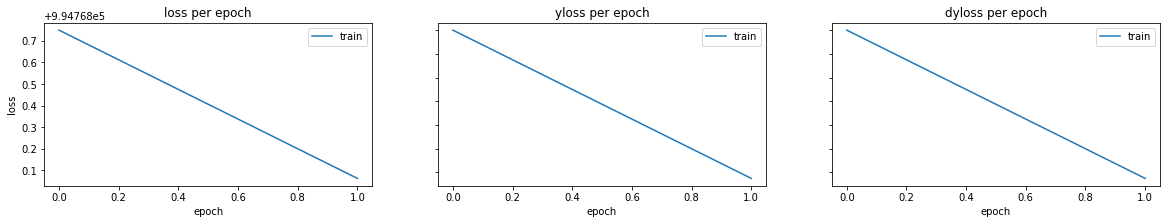

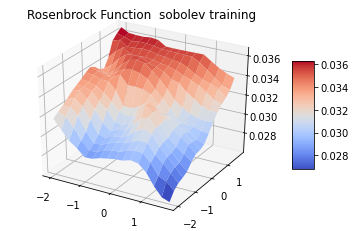

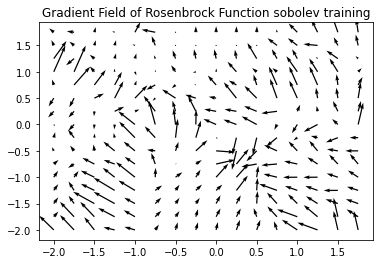

In [136]:
with_derivative = True
name_function = 'Rosenbrock Function  sobolev training'
name_grad = 'Gradient Field of Rosenbrock Function sobolev training'
model, test_loss = run_train(MLP_Relu, model_kwargs,  with_derivative, name_function, name_grad)

## **7.3) Siren**

Epoch 0: train loss: 994707.0, y loss : 304960.15625, dy loss : 689746.8125
Epoch 1: train loss: 994618.6875, y loss : 304960.5625, dy loss : 689658.125
test loss: 646245.5625, y loss : 163844.015625, dy loss : 482401.5625


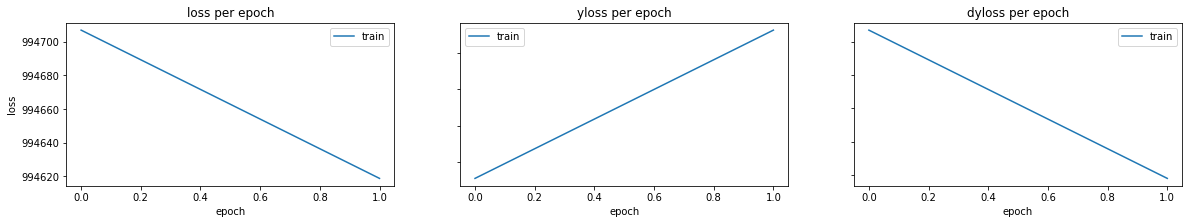

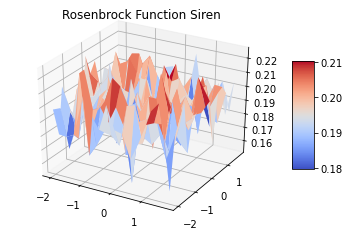

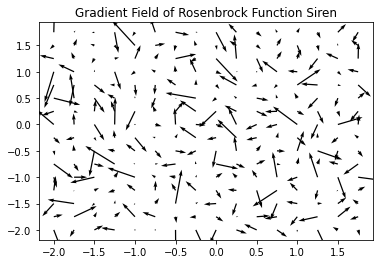

In [137]:
with_derivative = True
name_function = 'Rosenbrock Function Siren'
name_grad = 'Gradient Field of Rosenbrock Function Siren'

model_kwargs_tmp = model_kwargs.copy()
model_kwargs_tmp.update({"outermost_linear" : True})
model, test_loss = run_train(tf_Siren, model_kwargs_tmp,  with_derivative, name_function, name_grad)

## **7.4) Differential ML**

In [138]:
generator = Generator(callable_function = RosenbrockFunction, callable_function_deriv = RosenbrockDeriv, 
                      min_x = min_x, max_x = max_x)

graph_name = "Rosenbrock Differential ML"
name_function = 'Rosenbrock Function Differential ML'
name_grad = 'Gradient Field of Rosenbrock Function Differential ML'

### **siren = False**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 68604.47
standard_dyloss : 219093.78
differential_yloss : 50141.938
differential_dyloss : 219697.42
[[68604.47], [219093.78], [50141.938], [219697.42]]


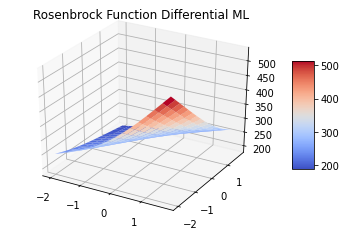

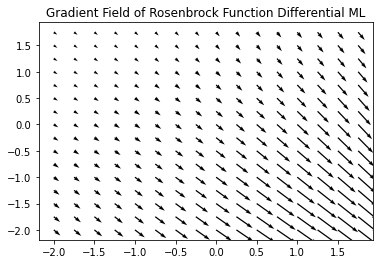

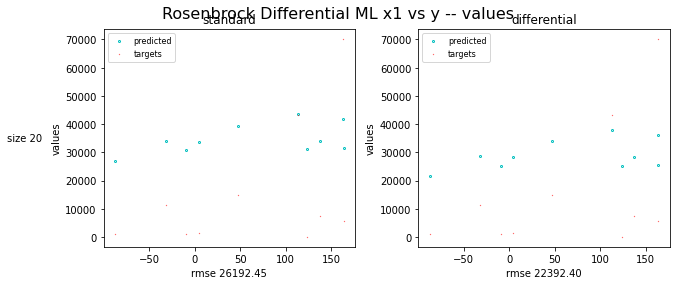

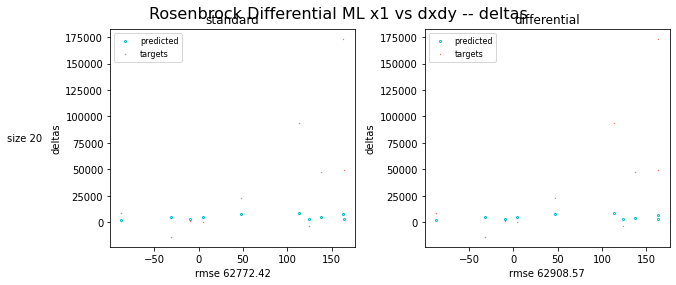

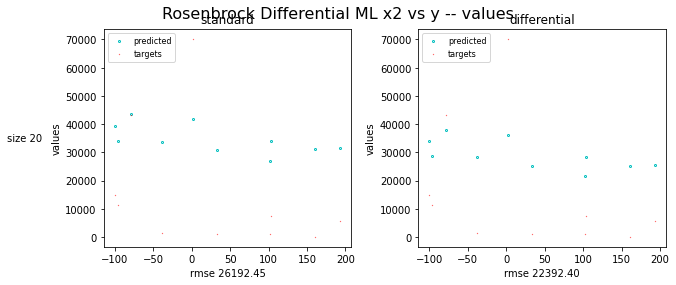

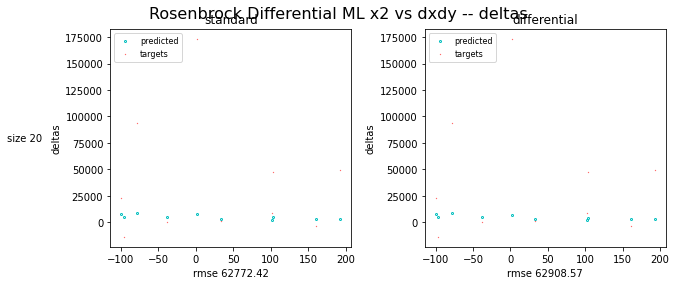

In [139]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad)

### **siren = True**

simulating training, valid and test sets
done
initializing neural appropximator
done

size 20



standard_yloss : 962673800.0
standard_dyloss : 31562230000.0
differential_yloss : 1134583200.0
differential_dyloss : 12763123000.0
[[962673800.0], [31562230000.0], [1134583200.0], [12763123000.0]]


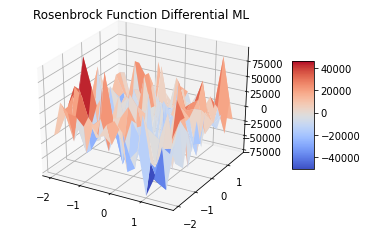

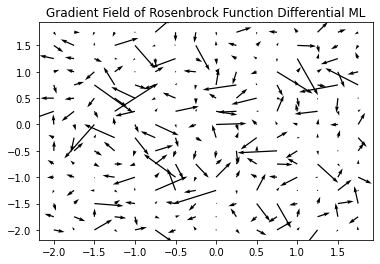

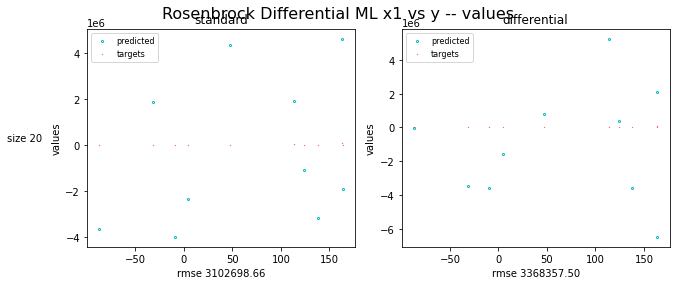

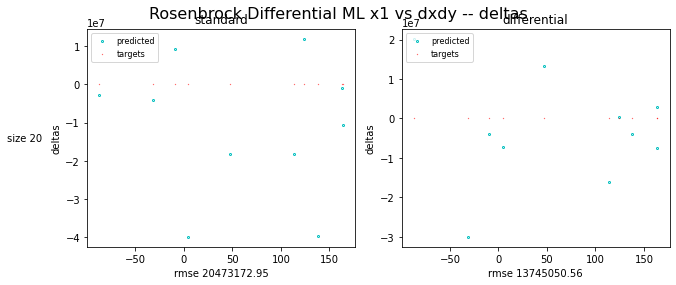

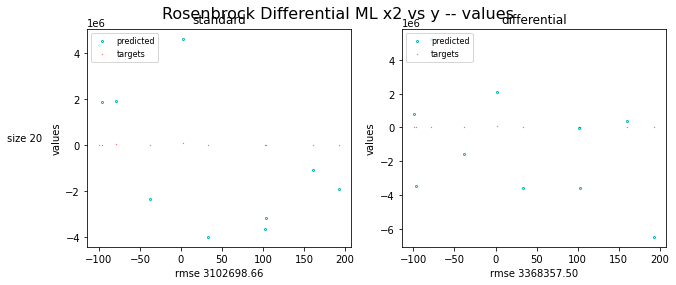

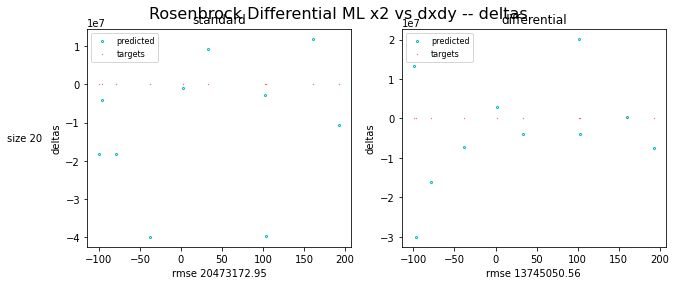

In [140]:
regressor, loss = run_diffML_train(graph_name, generator, generator_kwargs, name_function, name_grad, siren = True)

## **1.5) twin_net with siren**

Epoch 0: train loss: 998302.4375, y loss : 305390.0625, dy loss : 692912.375
train loss no scaled: 998302.4375, y loss  no scaled : 305390.0625, dy loss  no scaled: 692912.375
Epoch 1: train loss: 992854.125, y loss : 305081.8125, dy loss : 687772.3125
train loss no scaled: 992854.125, y loss  no scaled : 305081.8125, dy loss  no scaled: 687772.3125

test loss: 648344.625, y loss : 164050.890625, dy loss : 484293.75
test loss no scaled: 648344.640625, y loss  no scaled : 164050.890625, dy loss  no scaled: 484293.75


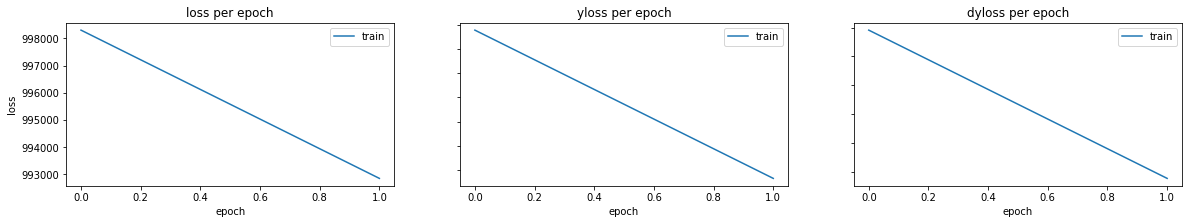

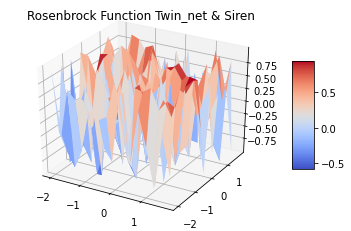

In [141]:
with_derivative = True      
name_function = 'Rosenbrock Function Twin_net & Siren'
name_grad = 'Gradient Field of Rosenbrock Function Twin_net & Siren'

twinNet, loss = run_twinNet_train(model_class = Siren, 
                                  model_kwargs = siren_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

## **7.6) twin_net with MLP**

Epoch 0: train loss: 994407.125, y loss : 304712.78125, dy loss : 689694.375
train loss no scaled: 994407.15625, y loss  no scaled : 304712.78125, dy loss  no scaled: 689694.375
Epoch 1: train loss: 994406.0, y loss : 304711.59375, dy loss : 689694.375
train loss no scaled: 994405.96875, y loss  no scaled : 304711.59375, dy loss  no scaled: 689694.375

test loss: 646031.75, y loss : 163652.15625, dy loss : 482379.59375
test loss no scaled: 646031.75, y loss  no scaled : 163652.15625, dy loss  no scaled: 482379.59375


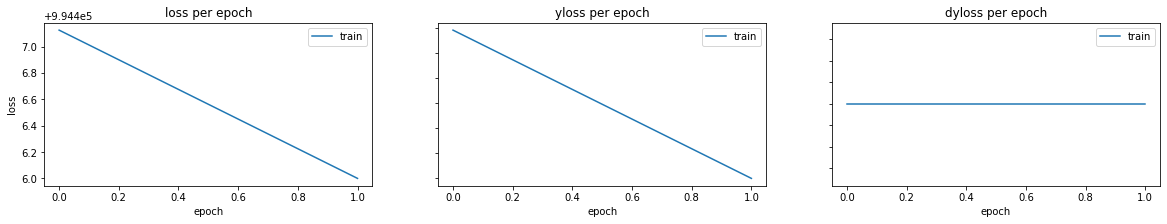

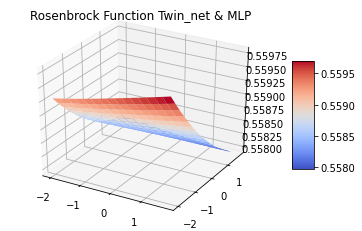

In [142]:
with_derivative = True      
name_function = 'Rosenbrock Function Twin_net & MLP'
name_grad = 'Gradient Field of Rosenbrock Function Twin_net & MLP'

twinNet, loss = run_twinNet_train(model_class = MLP, 
                                  model_kwargs = mlp_model_kwargs, 
                                  with_derivative = with_derivative,
                                  name_function = name_function, 
                                  name_grad = name_grad
                                  )

#**8) End**